# Model Comparison - ArXiv QA Test Results

This notebook compares the performance of different models on the `vidore_arxivqa_test_subsampled` dataset by analyzing their evaluation metrics.

In [3]:
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pprint import pp
from IPython.display import display, Markdown, Latex

# Set the style for our plots
plt.style.use('ggplot')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = [12, 8]

## Load the metrics files for all models

In [4]:
# Define the results directory
results_dir = "./results/"

# Find all arxivqa_test_subsampled_metrics.json files
arxivqa_files = []
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file == "vidore_arxivqa_test_subsampled_metrics.json":
            arxivqa_files.append(os.path.join(root, file))

print(f"Found {len(arxivqa_files)} model result files for ArXiv QA test.")

Found 8 model result files for ArXiv QA test.


In [5]:
# Function to extract model name from file path
def get_model_name(file_path):
    # Extract the model directory name
    parts = file_path.split('/')
    model_dir = [p for p in parts if p != 'results' and 'vidore_arxivqa_test' not in p][-1]
    return model_dir

# Load all the metrics into a dictionary
model_metrics = {}

for file_path in arxivqa_files:
    model_name = get_model_name(file_path)
    
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    # Extract the metrics we want to compare
    metrics = data['metrics']['vidore/arxivqa_test_subsampled']
    model_metrics[model_name] = metrics
    
print(f"Loaded metrics for {len(model_metrics)} models.")
print("Models:")
for model in model_metrics.keys():
    print(f"- {model}")

Loaded metrics for 8 models.
Models:
- blip2-flan-t5-xl
- blip_Salesforce_blip-vqa-base
- clip_openai_clip-vit-base-patch32
- jina-clip-v1_jinaai_jina-clip-v1
- llava-interleave_llava-hf_llava-interleave-qwen-0.5b-hf
- siglip_google_siglip-so400m-patch14-384
- vit_google_vit-base-patch16-224-in21k
- jina-clip-v1_jinaai_jina-clip-v1_seg_2x2


## Extract and organize key metrics for comparison

In [8]:
# Define the metrics we want to compare
metric_types = ['ndcg', 'map', 'recall', 'precision']
k_values = [1, 3, 5, 10, 20, 50, 100]

# Create a pandas DataFrame to hold all metrics for easy comparison
all_metrics = []

for model_name, metrics in model_metrics.items():
    for metric_type in metric_types:
        for k in k_values:
            metric_key = f"{metric_type}_at_{k}"
            if metric_key in metrics:
                all_metrics.append({
                    'Model': model_name,
                    'Metric': metric_type,
                    'k': k,
                    'Value': metrics[metric_key]
                })

metrics_df = pd.DataFrame(all_metrics)
metrics_df.head(10)

Model Metric    k    Value
0  blip2-flan-t5-xl   ndcg    1  0.00200
1  blip2-flan-t5-xl   ndcg    3  0.00579
2  blip2-flan-t5-xl   ndcg    5  0.00819
3  blip2-flan-t5-xl   ndcg   10  0.00880
4  blip2-flan-t5-xl   ndcg   20  0.01601
5  blip2-flan-t5-xl   ndcg   50  0.02882
6  blip2-flan-t5-xl   ndcg  100  0.04592
7  blip2-flan-t5-xl    map    1  0.00200
8  blip2-flan-t5-xl    map    3  0.00500
9  blip2-flan-t5-xl    map    5  0.00630

## Visualize the results

In [9]:
# Function to plot metrics by k value
def plot_metric(df, metric_name):
    plt.figure(figsize=(12, 6), dpi=300)
    
    # Filter for the specific metric
    metric_df = df[df['Metric'] == metric_name]
    
    # Create line plot
    sns.lineplot(data=metric_df, x='k', y='Value', hue='Model', marker='o', markersize=8)
    
    plt.title(f'{metric_name.upper()} at k for different models')
    plt.xlabel('k (cutoff)')
    plt.ylabel(f'{metric_name.upper()} Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

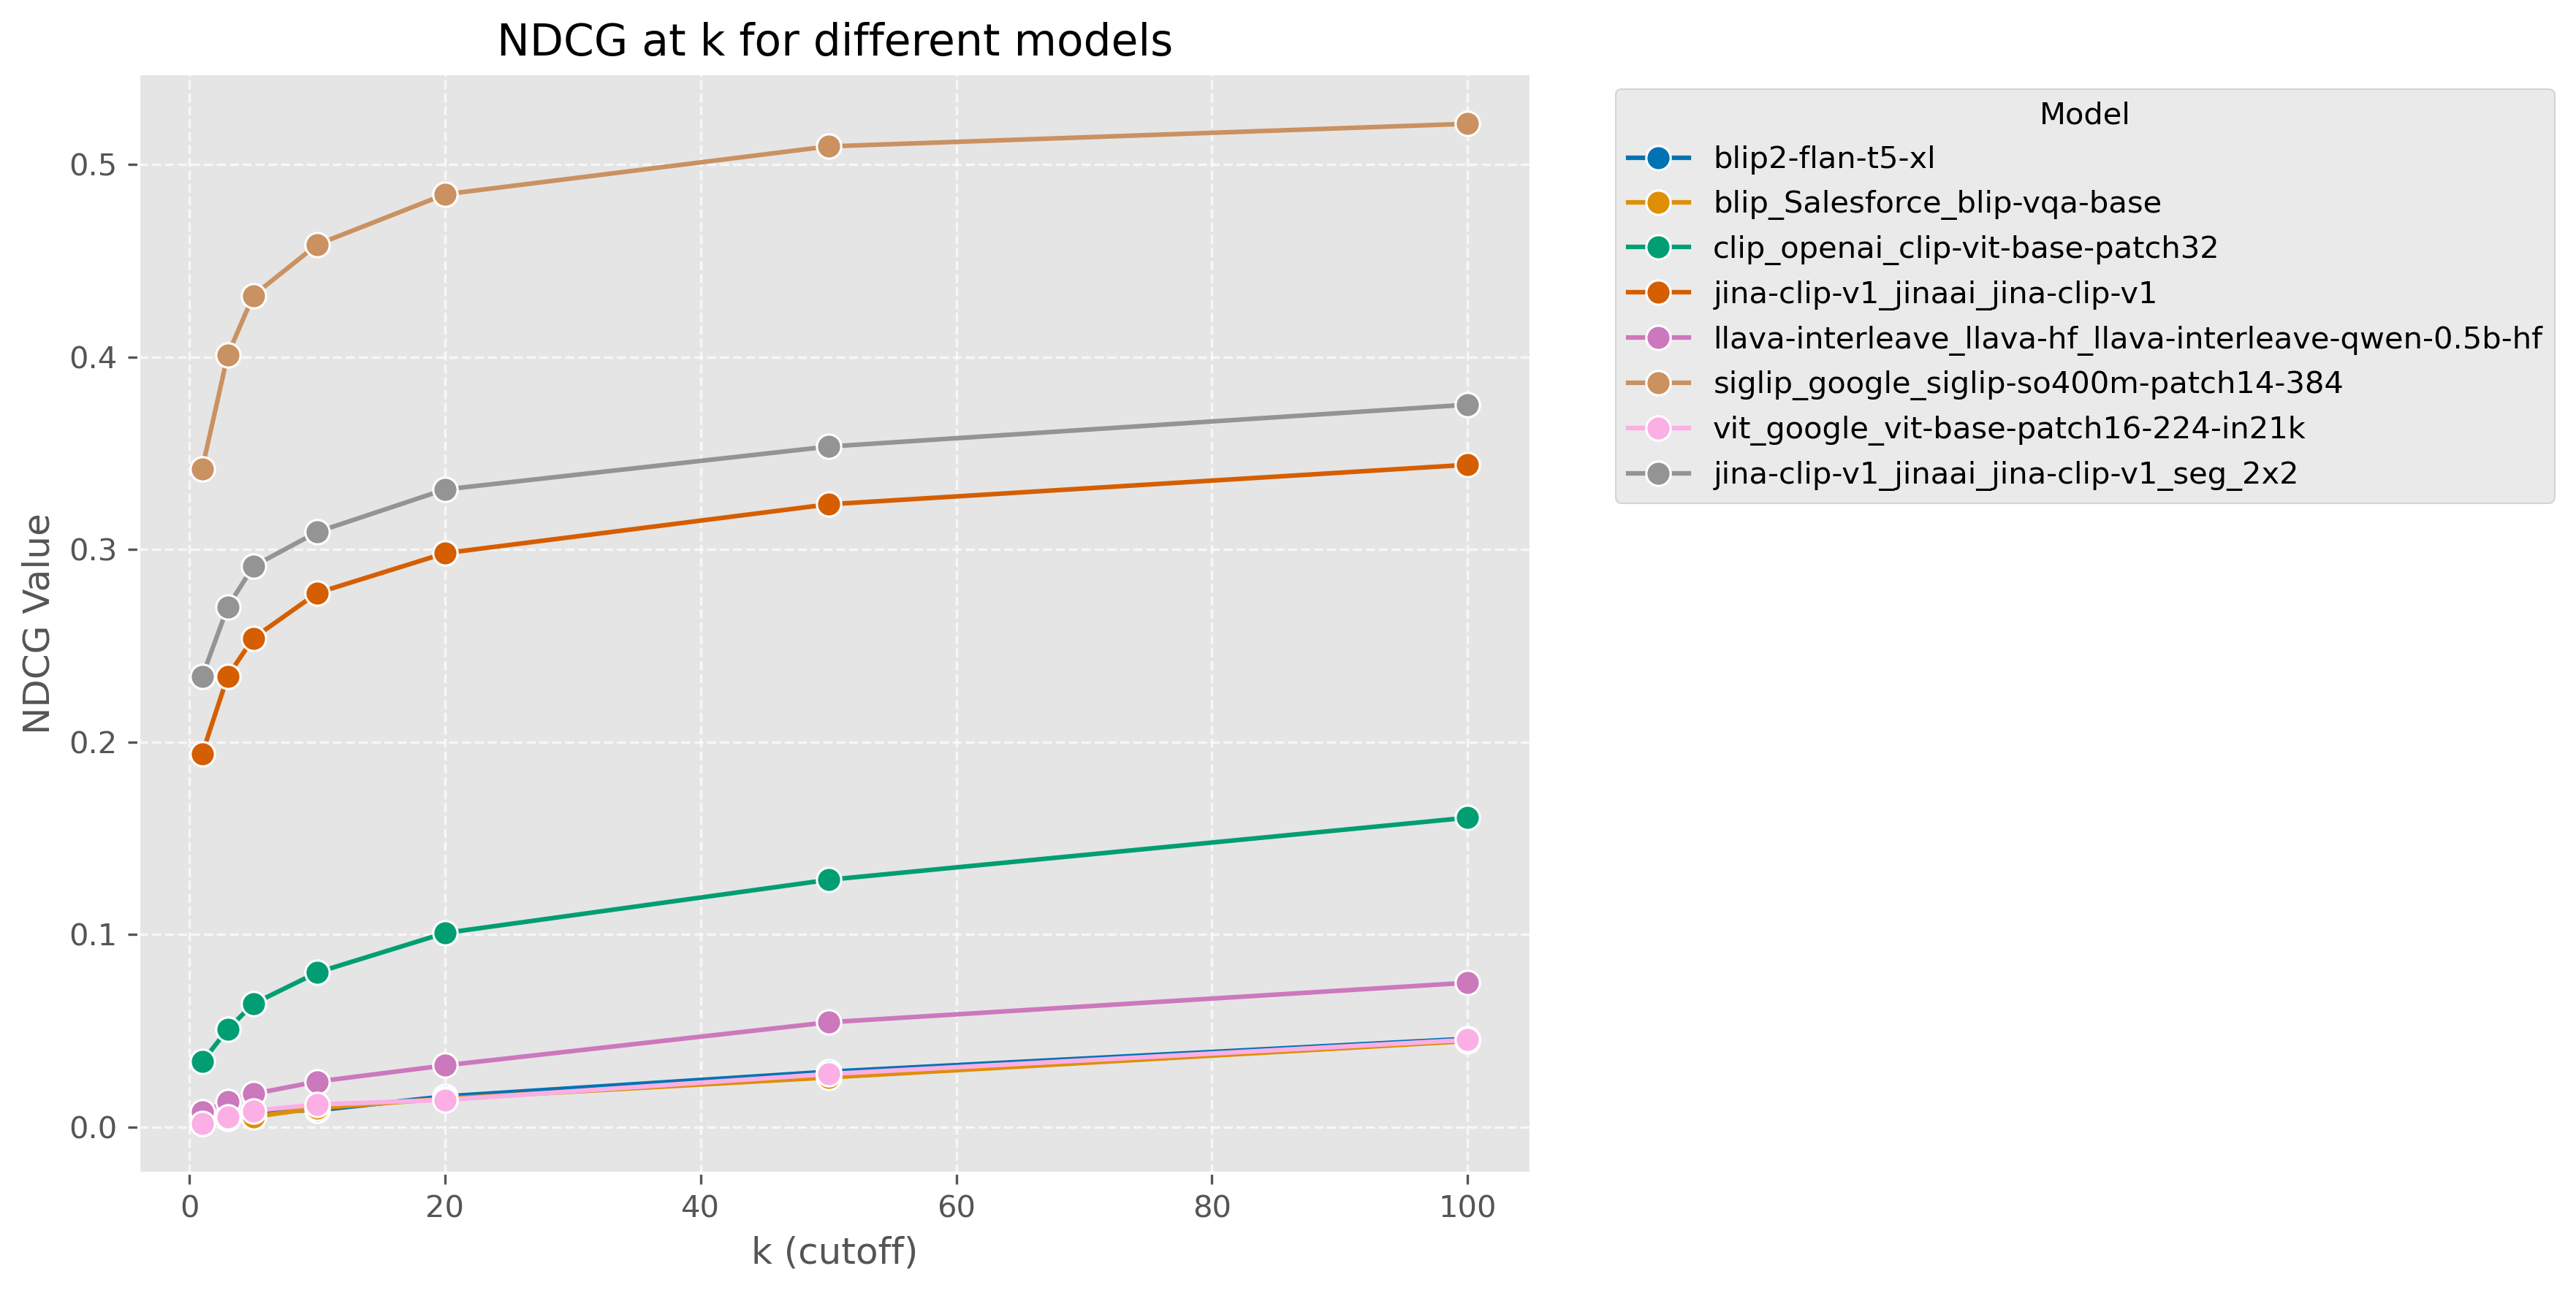

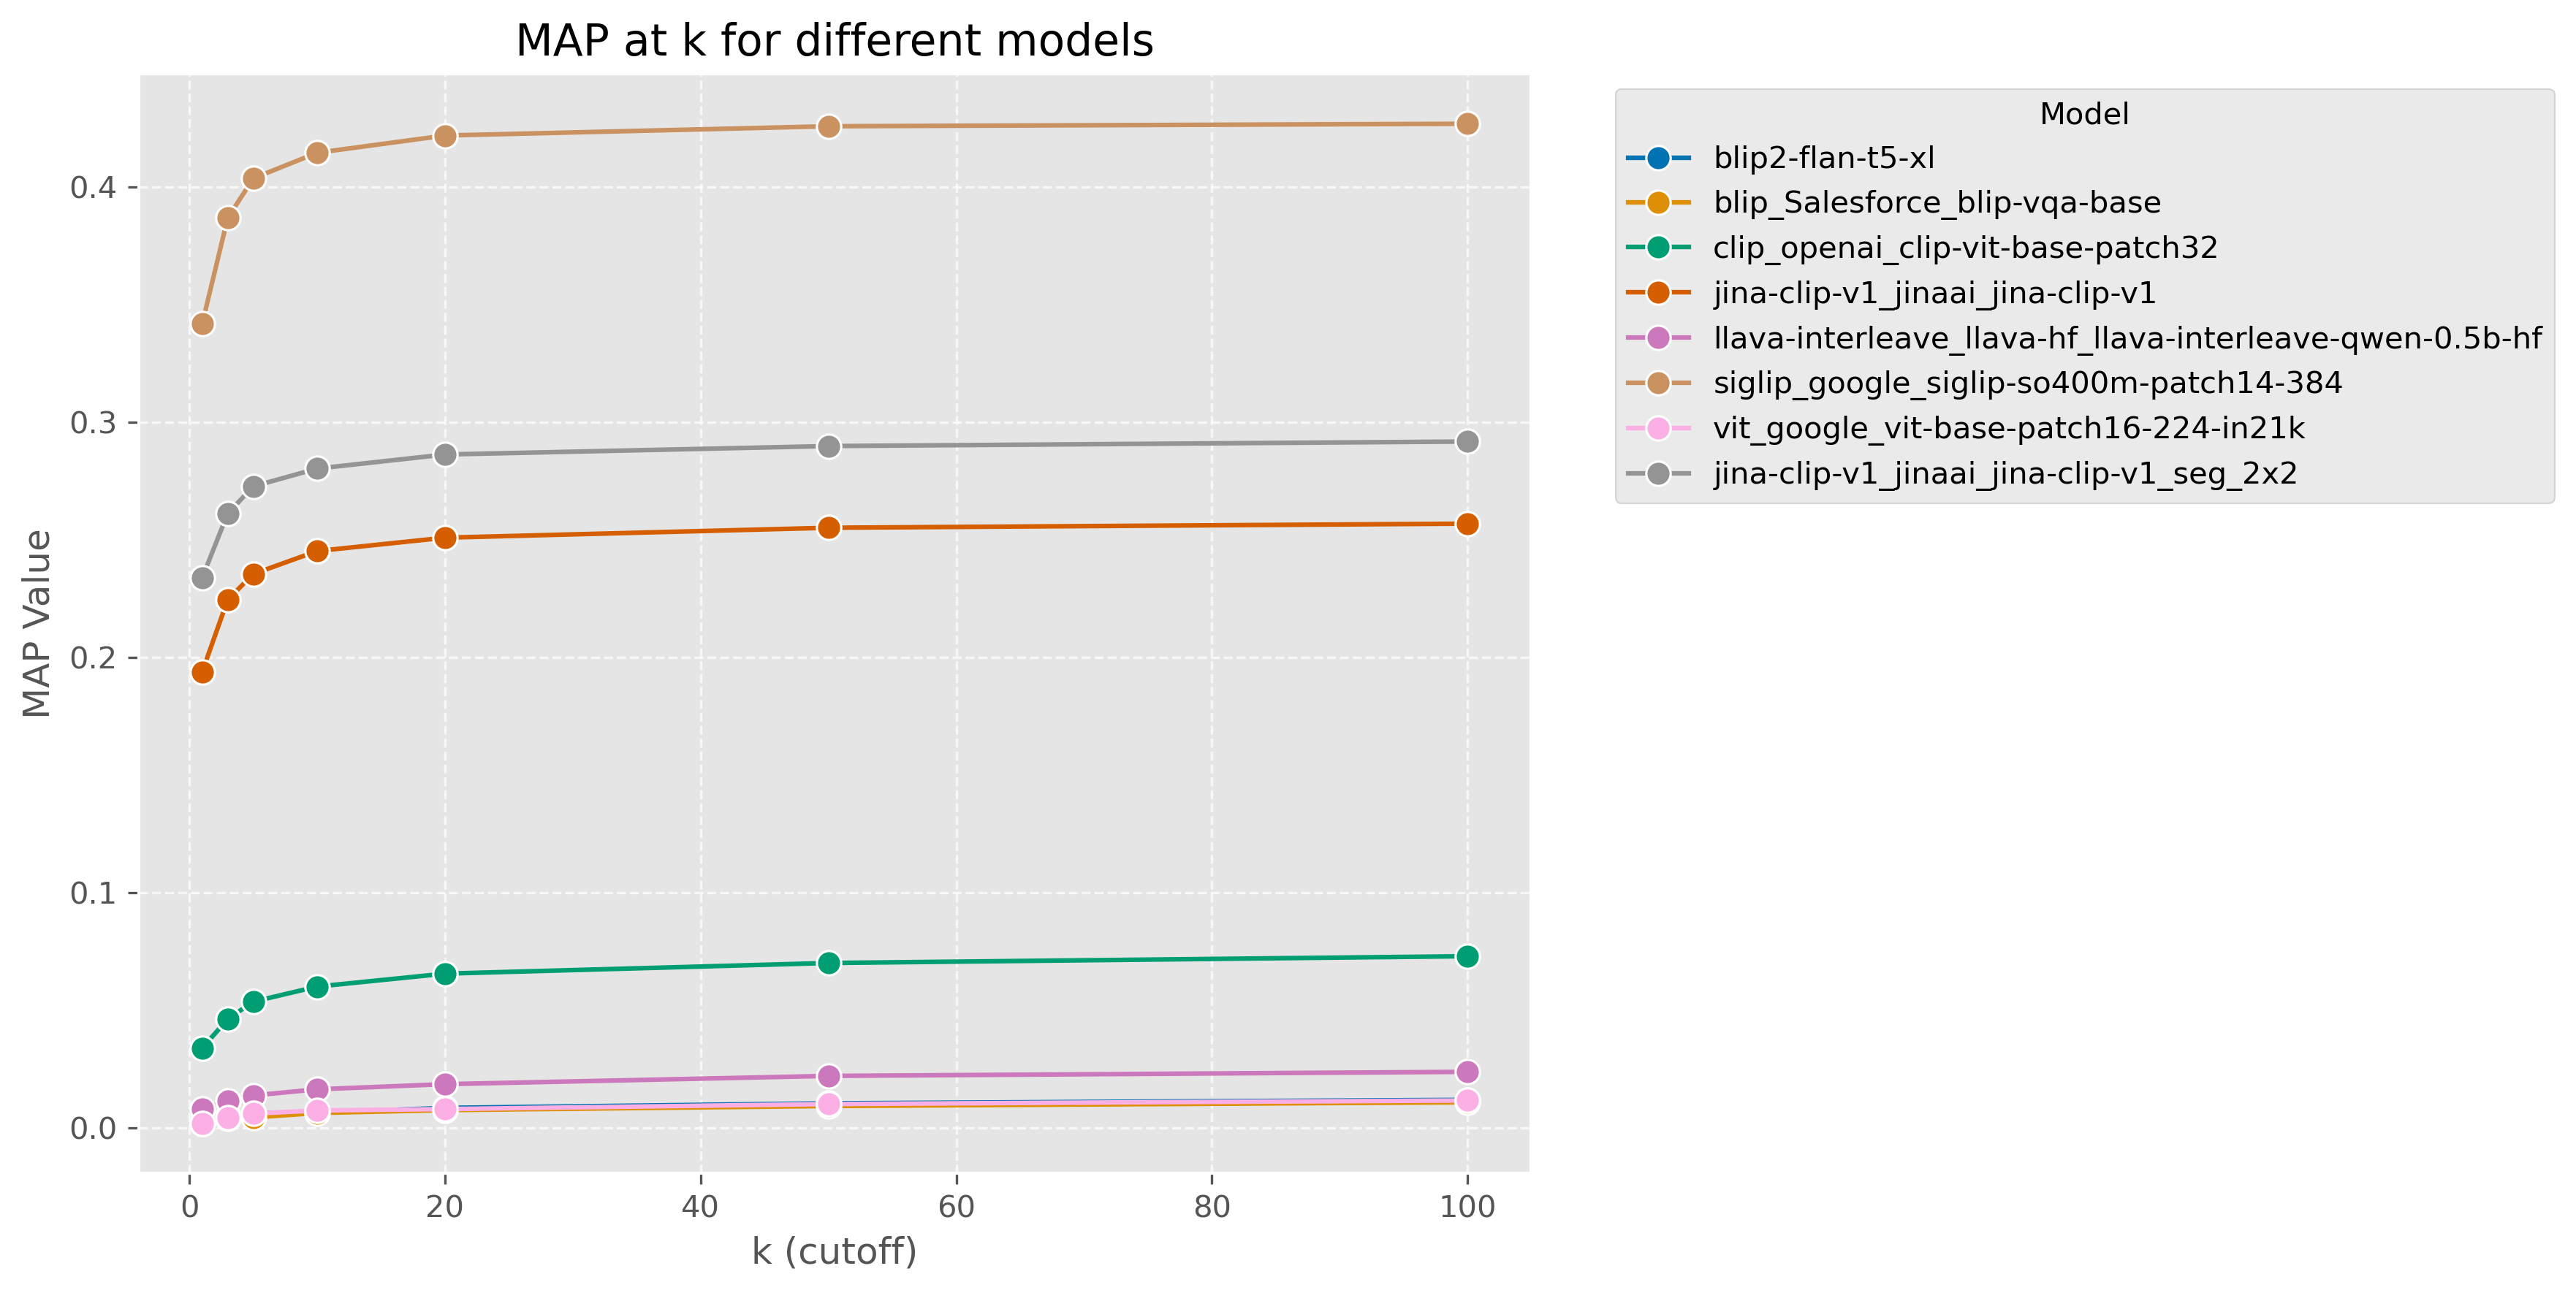

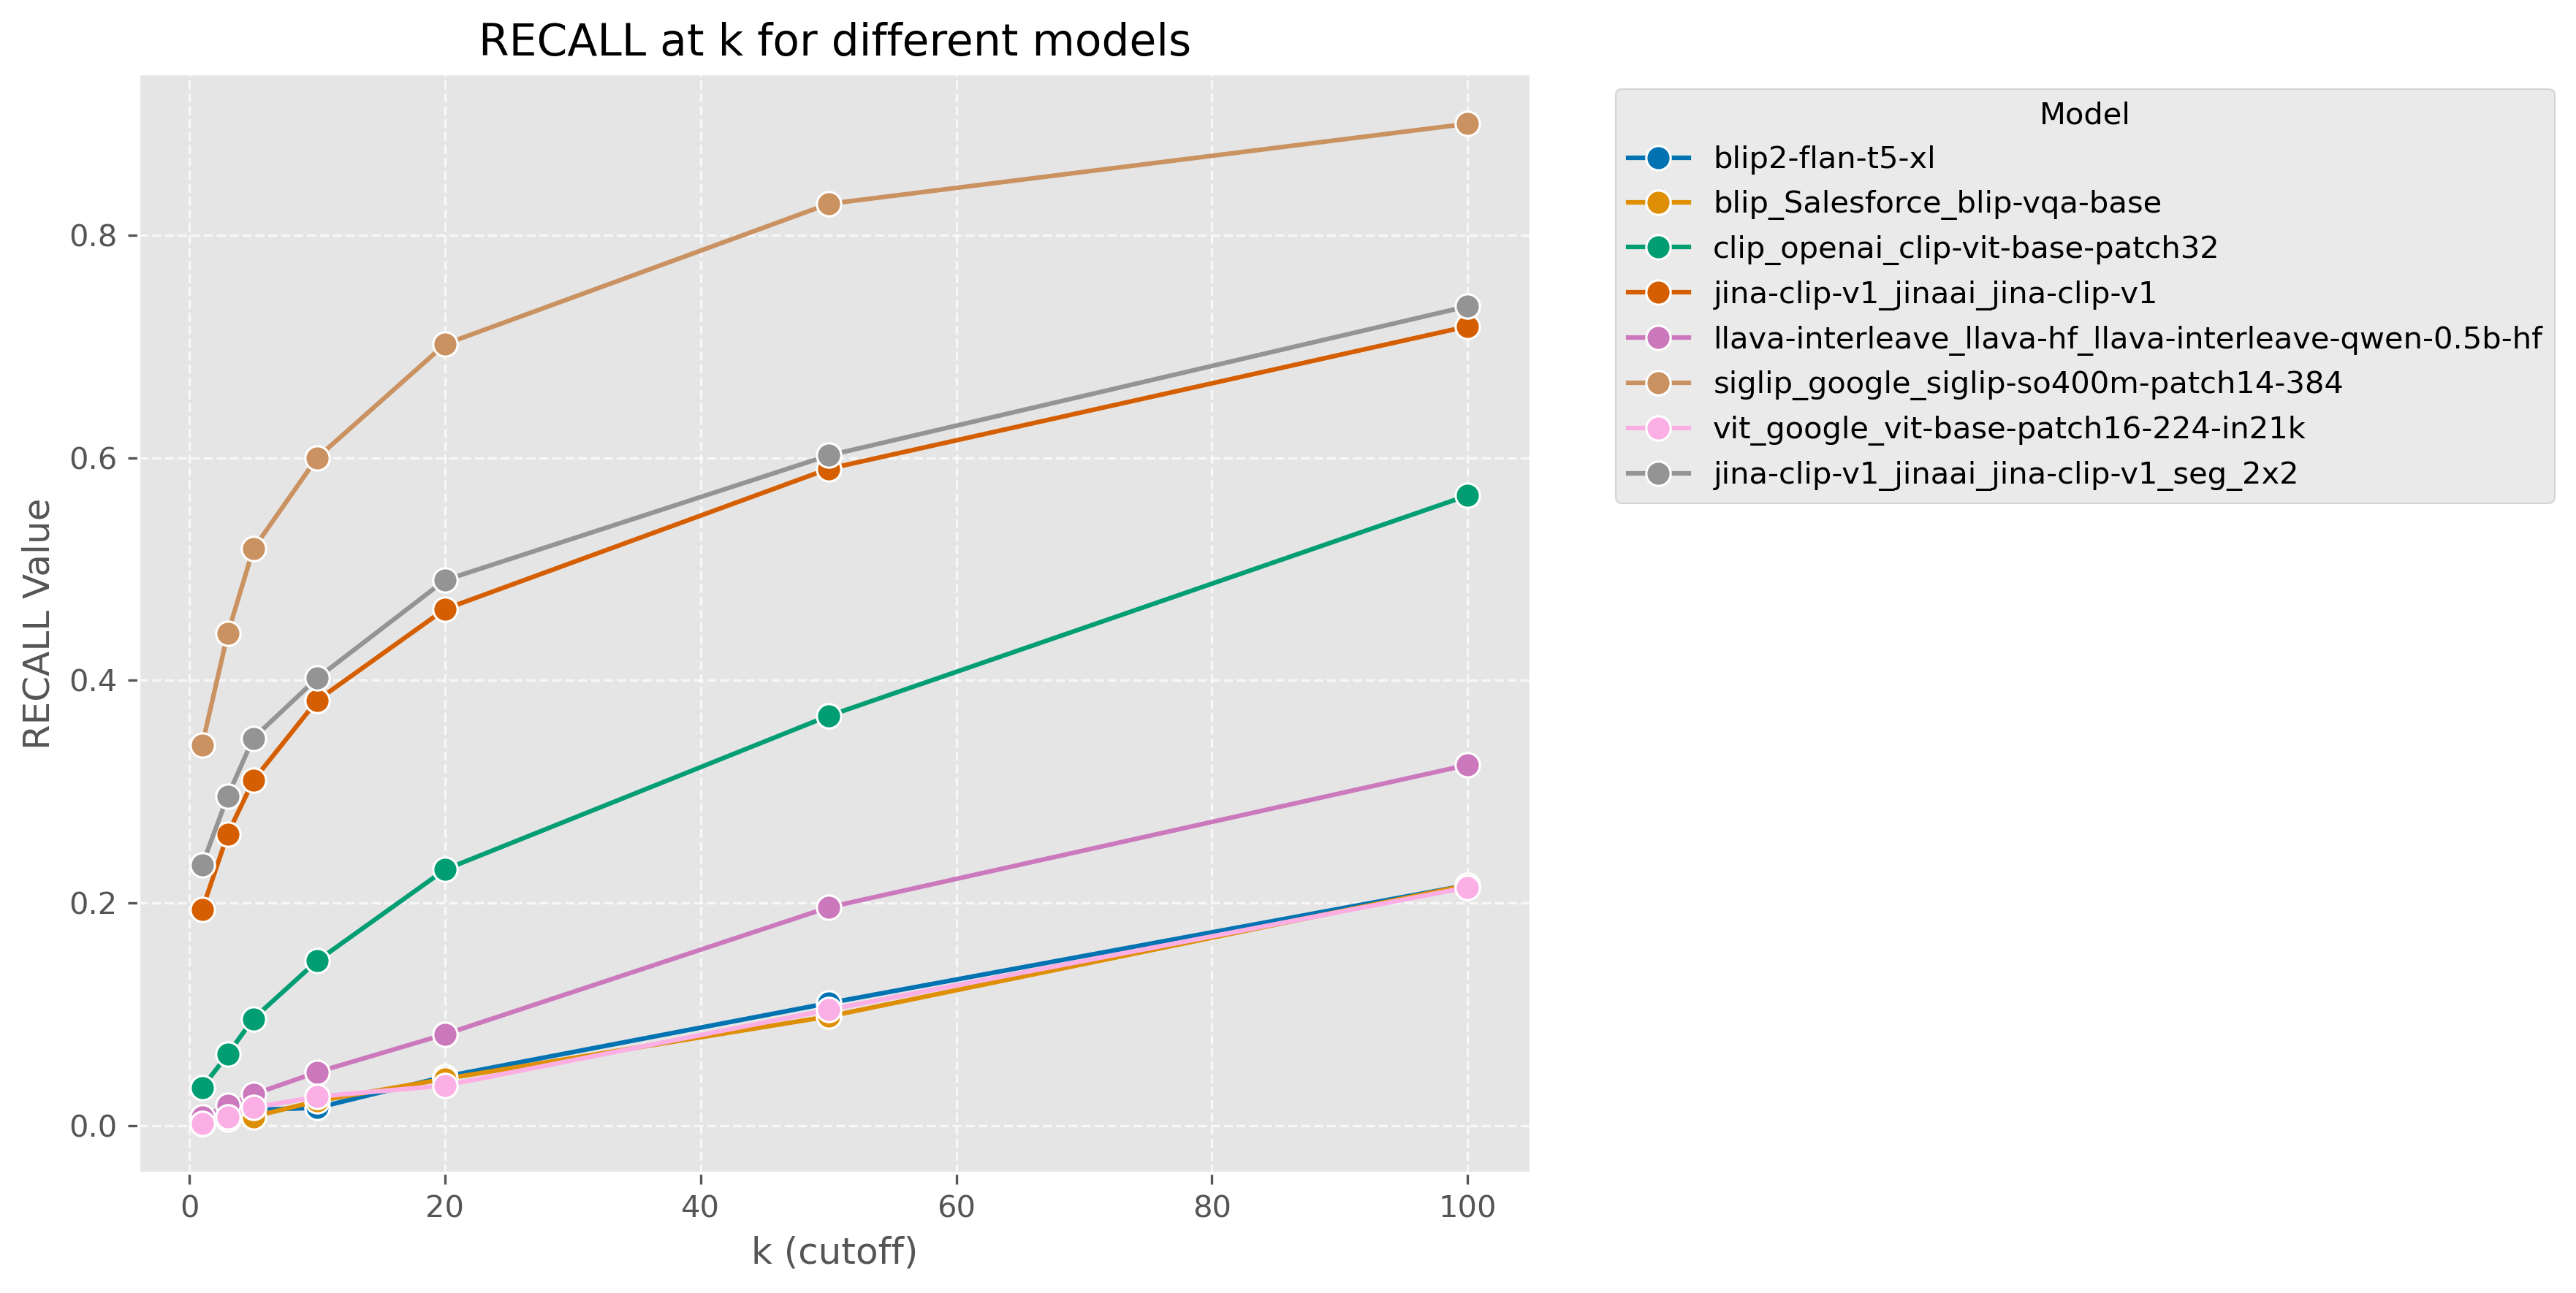

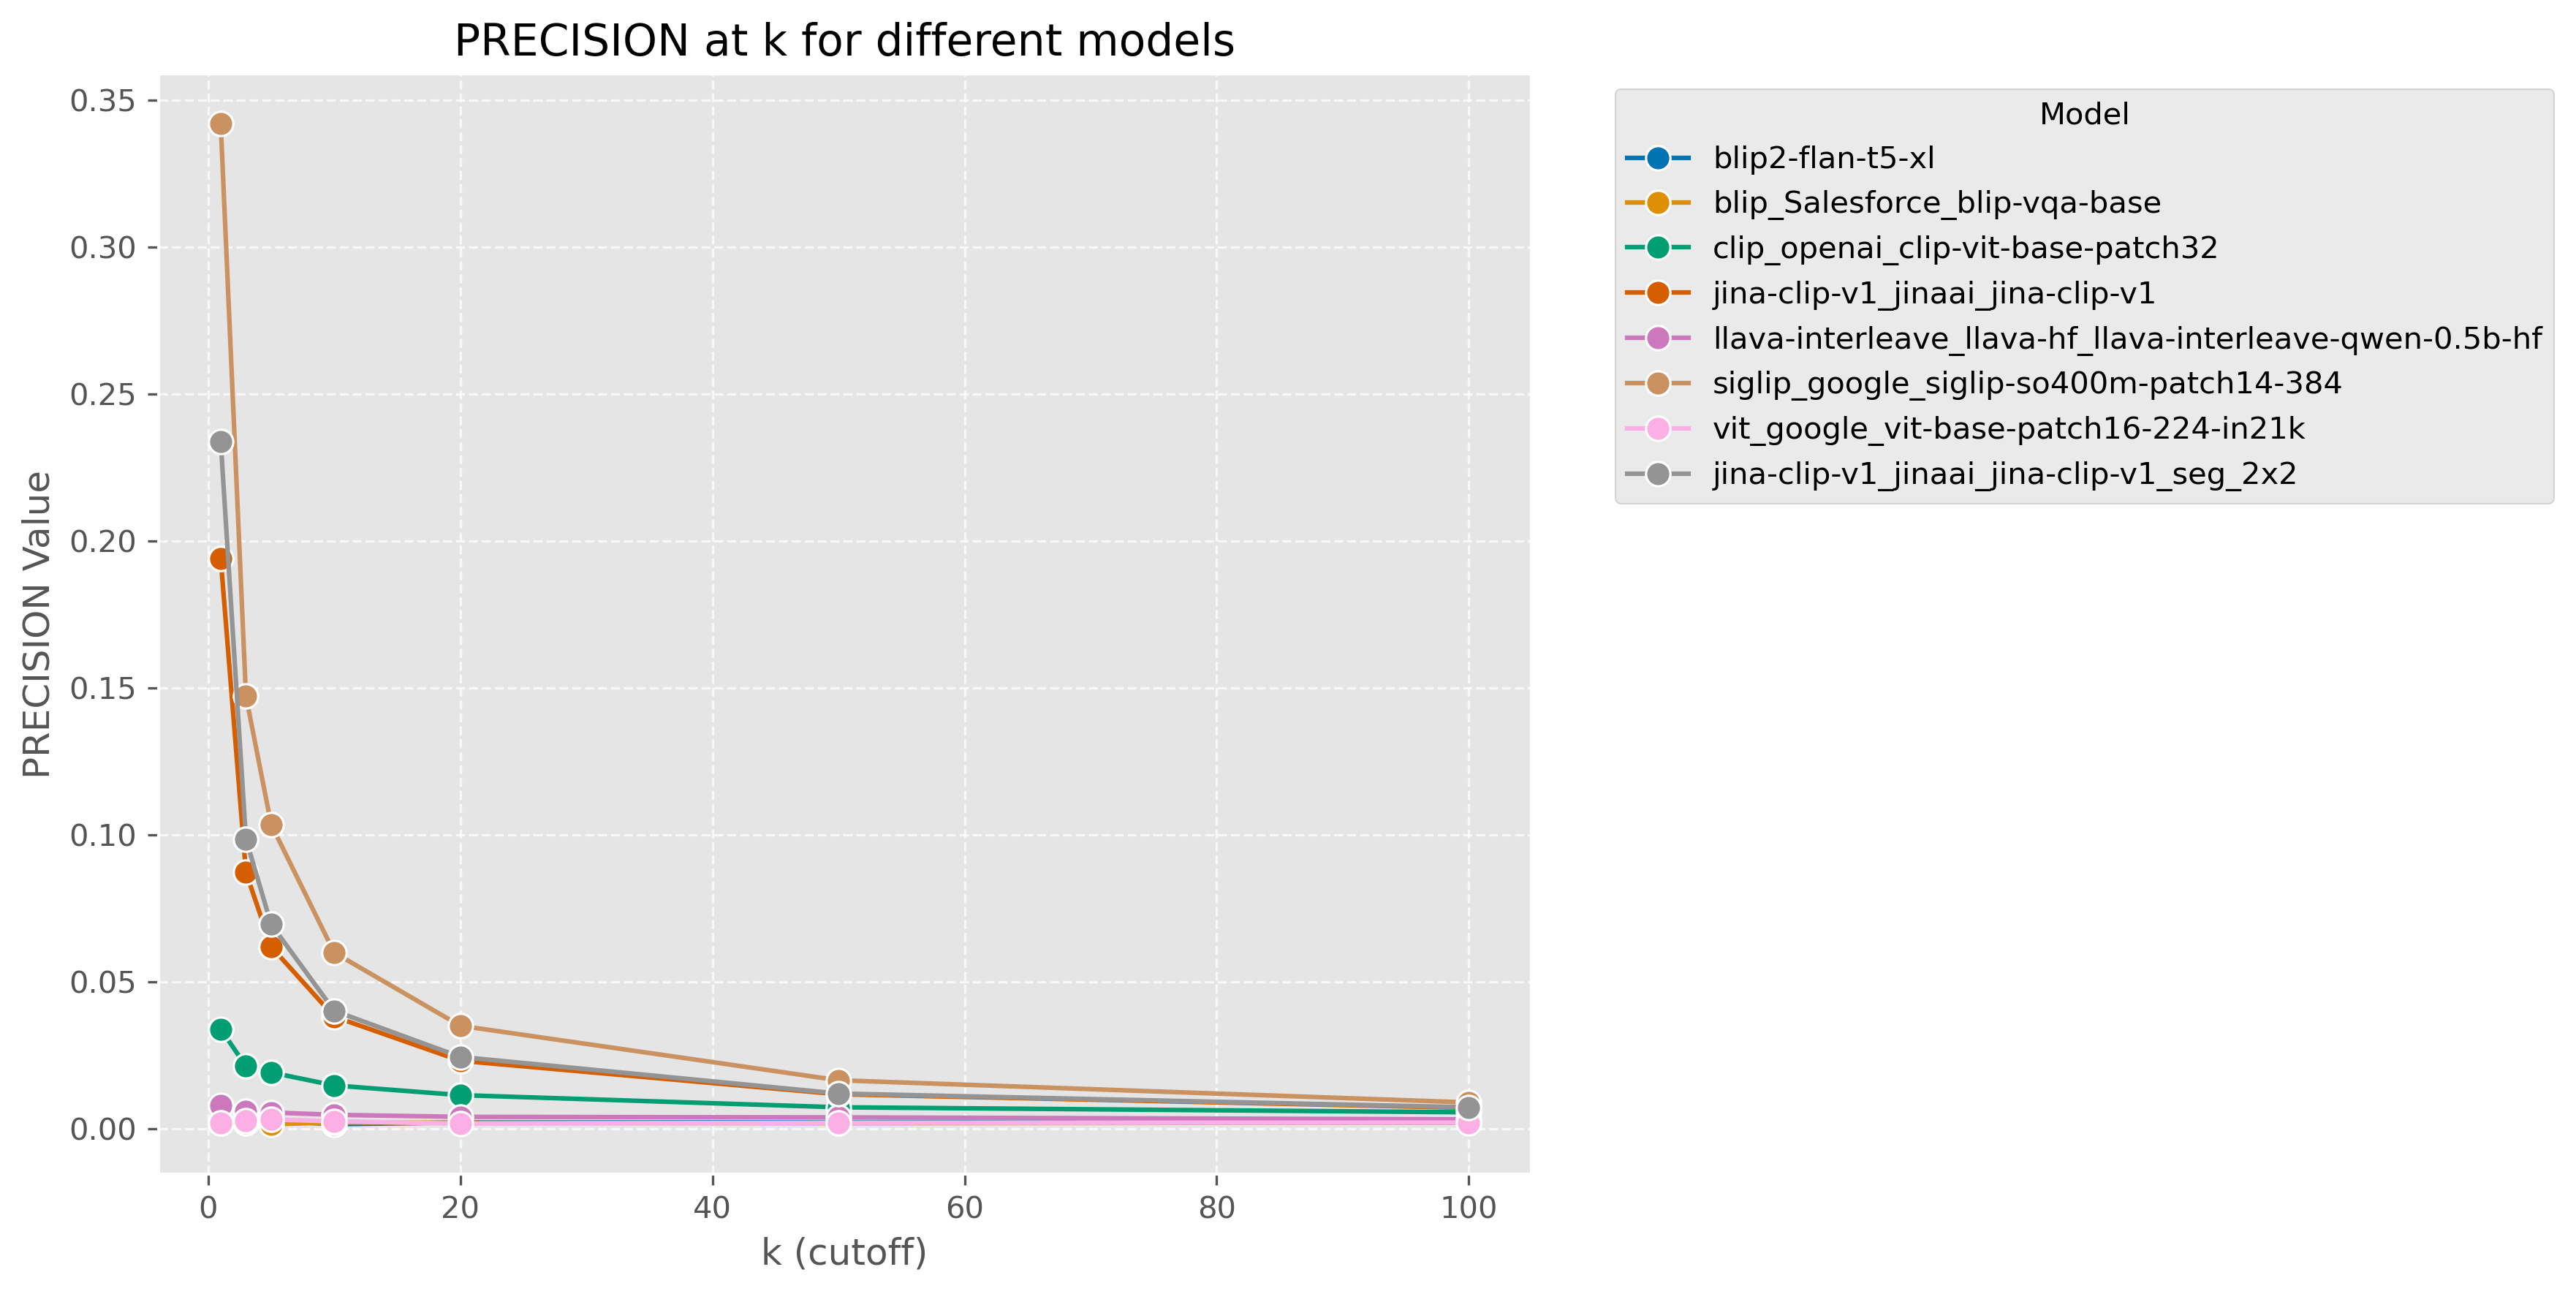

In [10]:
# Plot each metric type
for metric in metric_types:
    plot_metric(metrics_df, metric)

## Compare performance at specific cutoffs

In [11]:
# Function to create a bar chart comparing all models at a specific k value
def compare_at_k(df, k_value):
    plt.figure(figsize=(14, 10), dpi=300)
    
    # Filter for the specific k value
    k_df = df[df['k'] == k_value]
    
    # Create bar chart
    ax = sns.barplot(data=k_df, x='Model', y='Value', hue='Metric')

    plt.title(f'Metrics at k={k_value} for all models')
    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

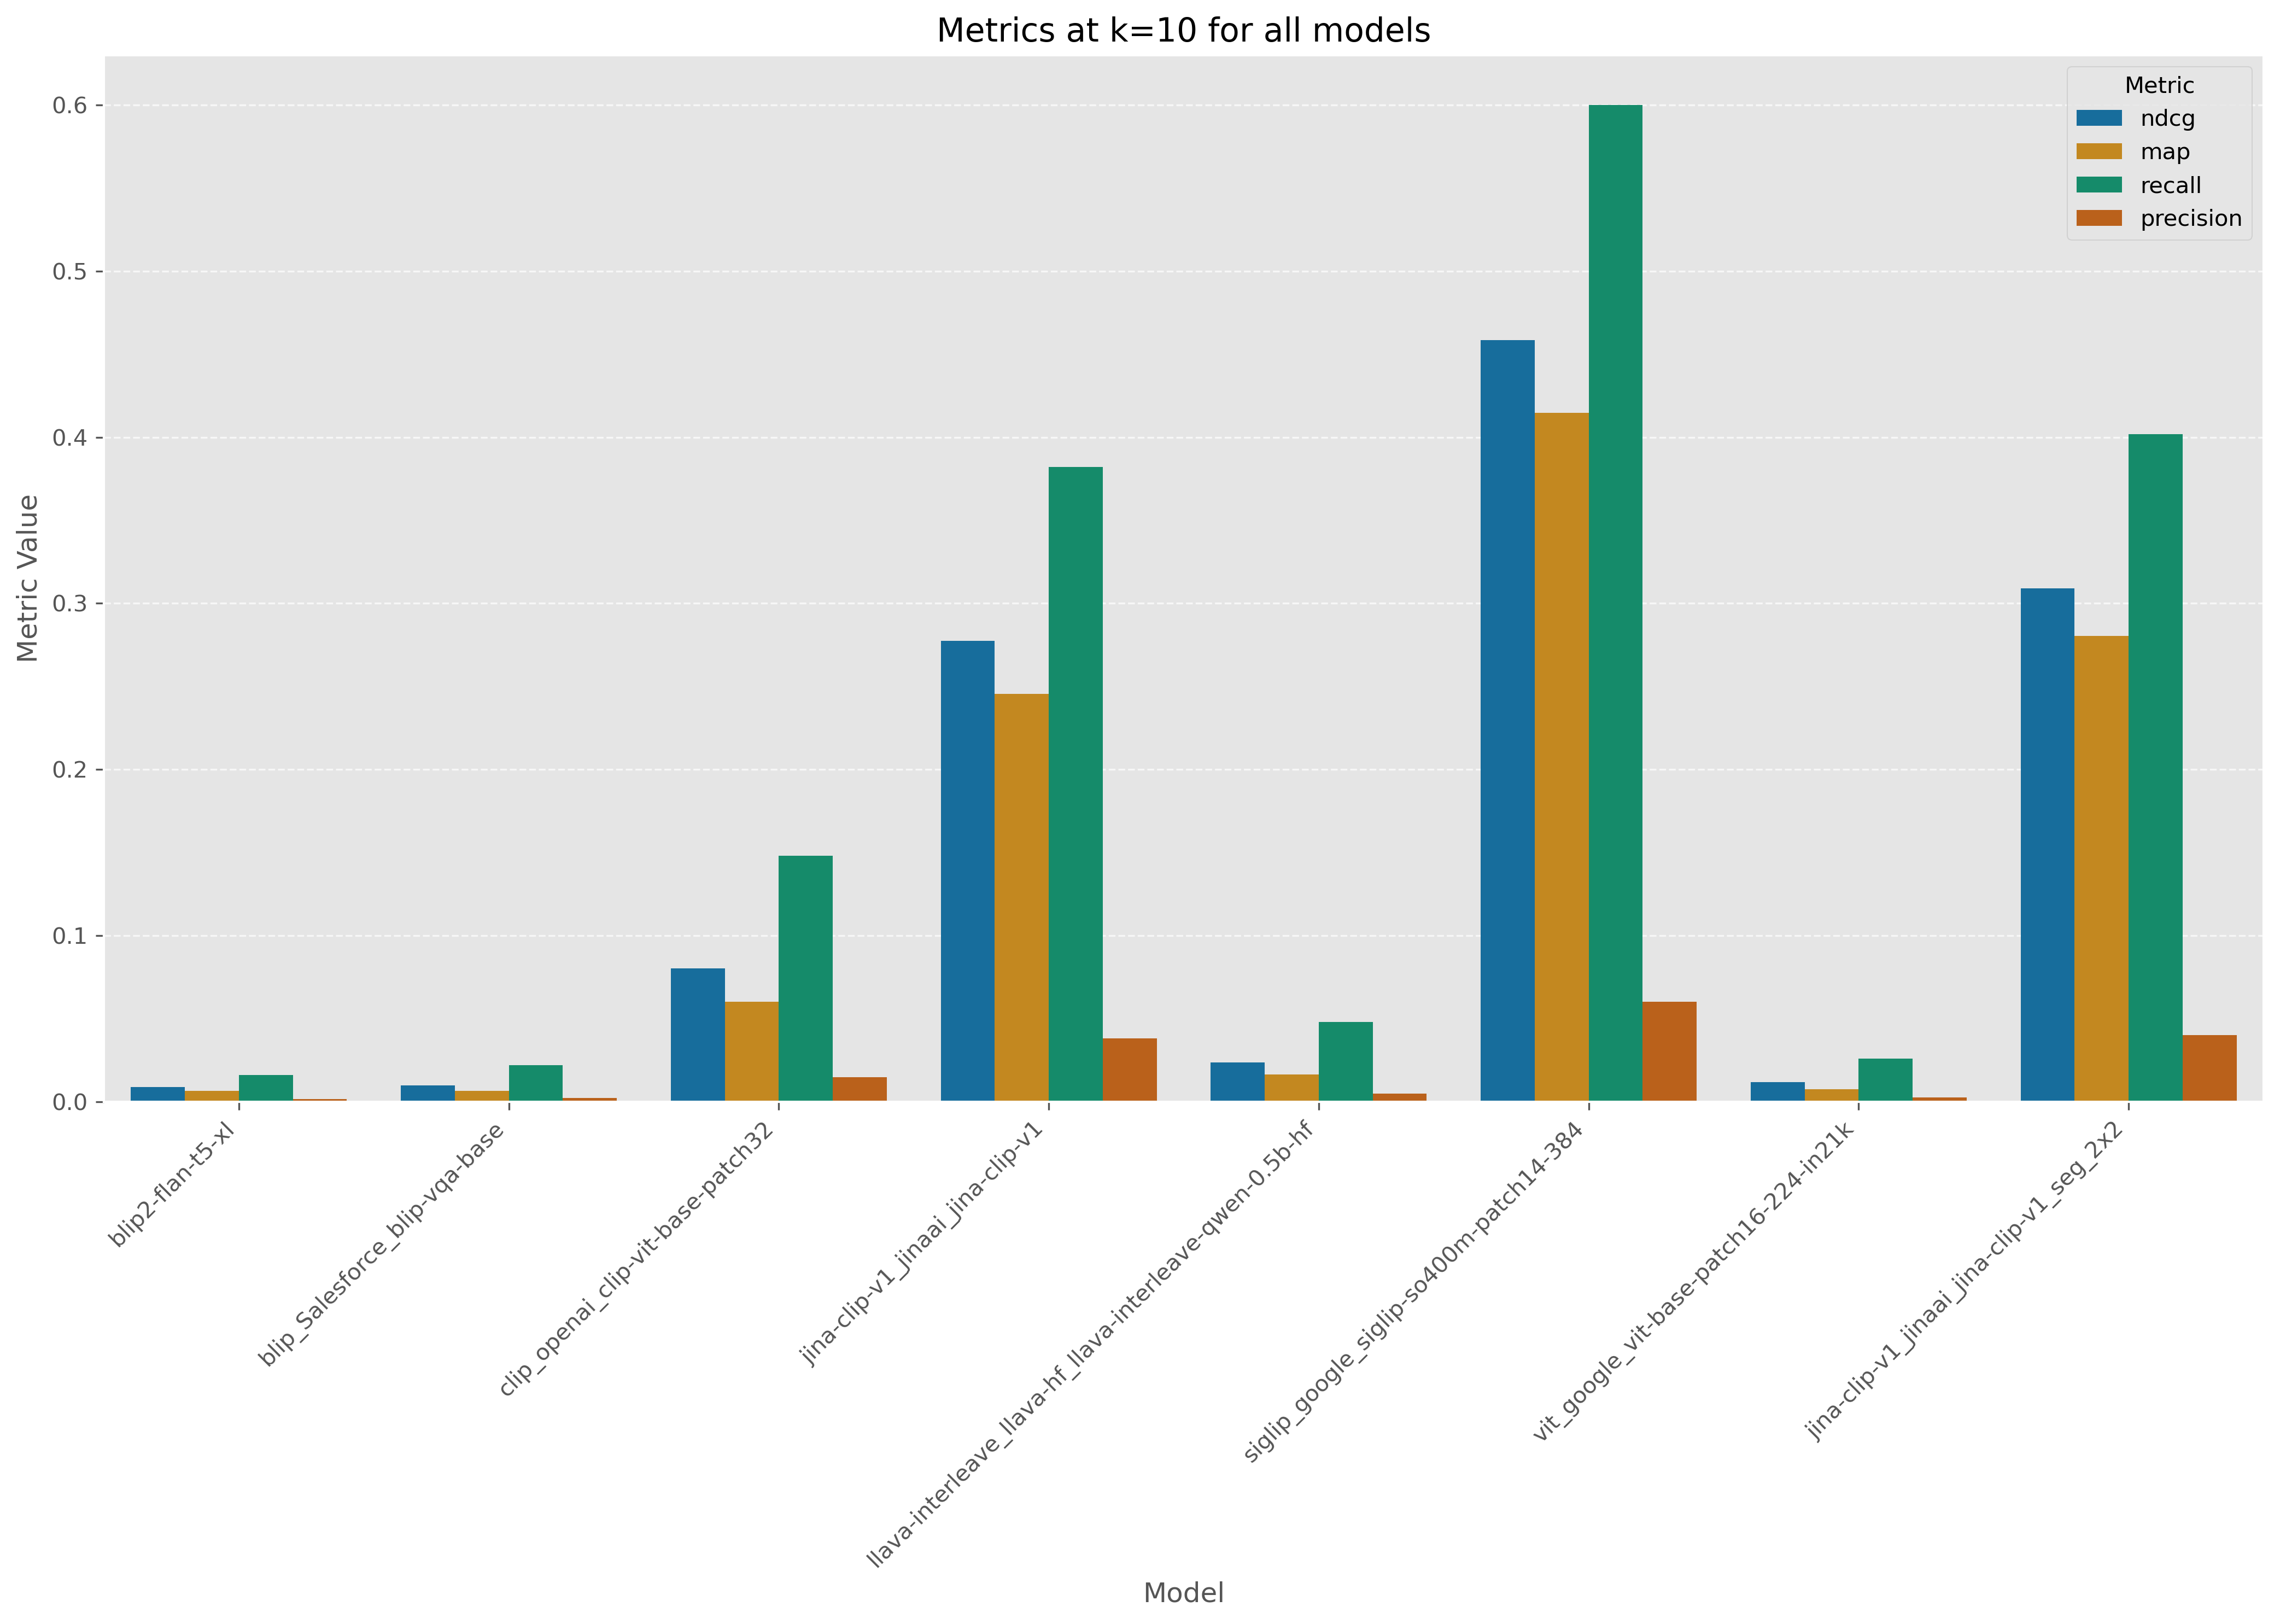

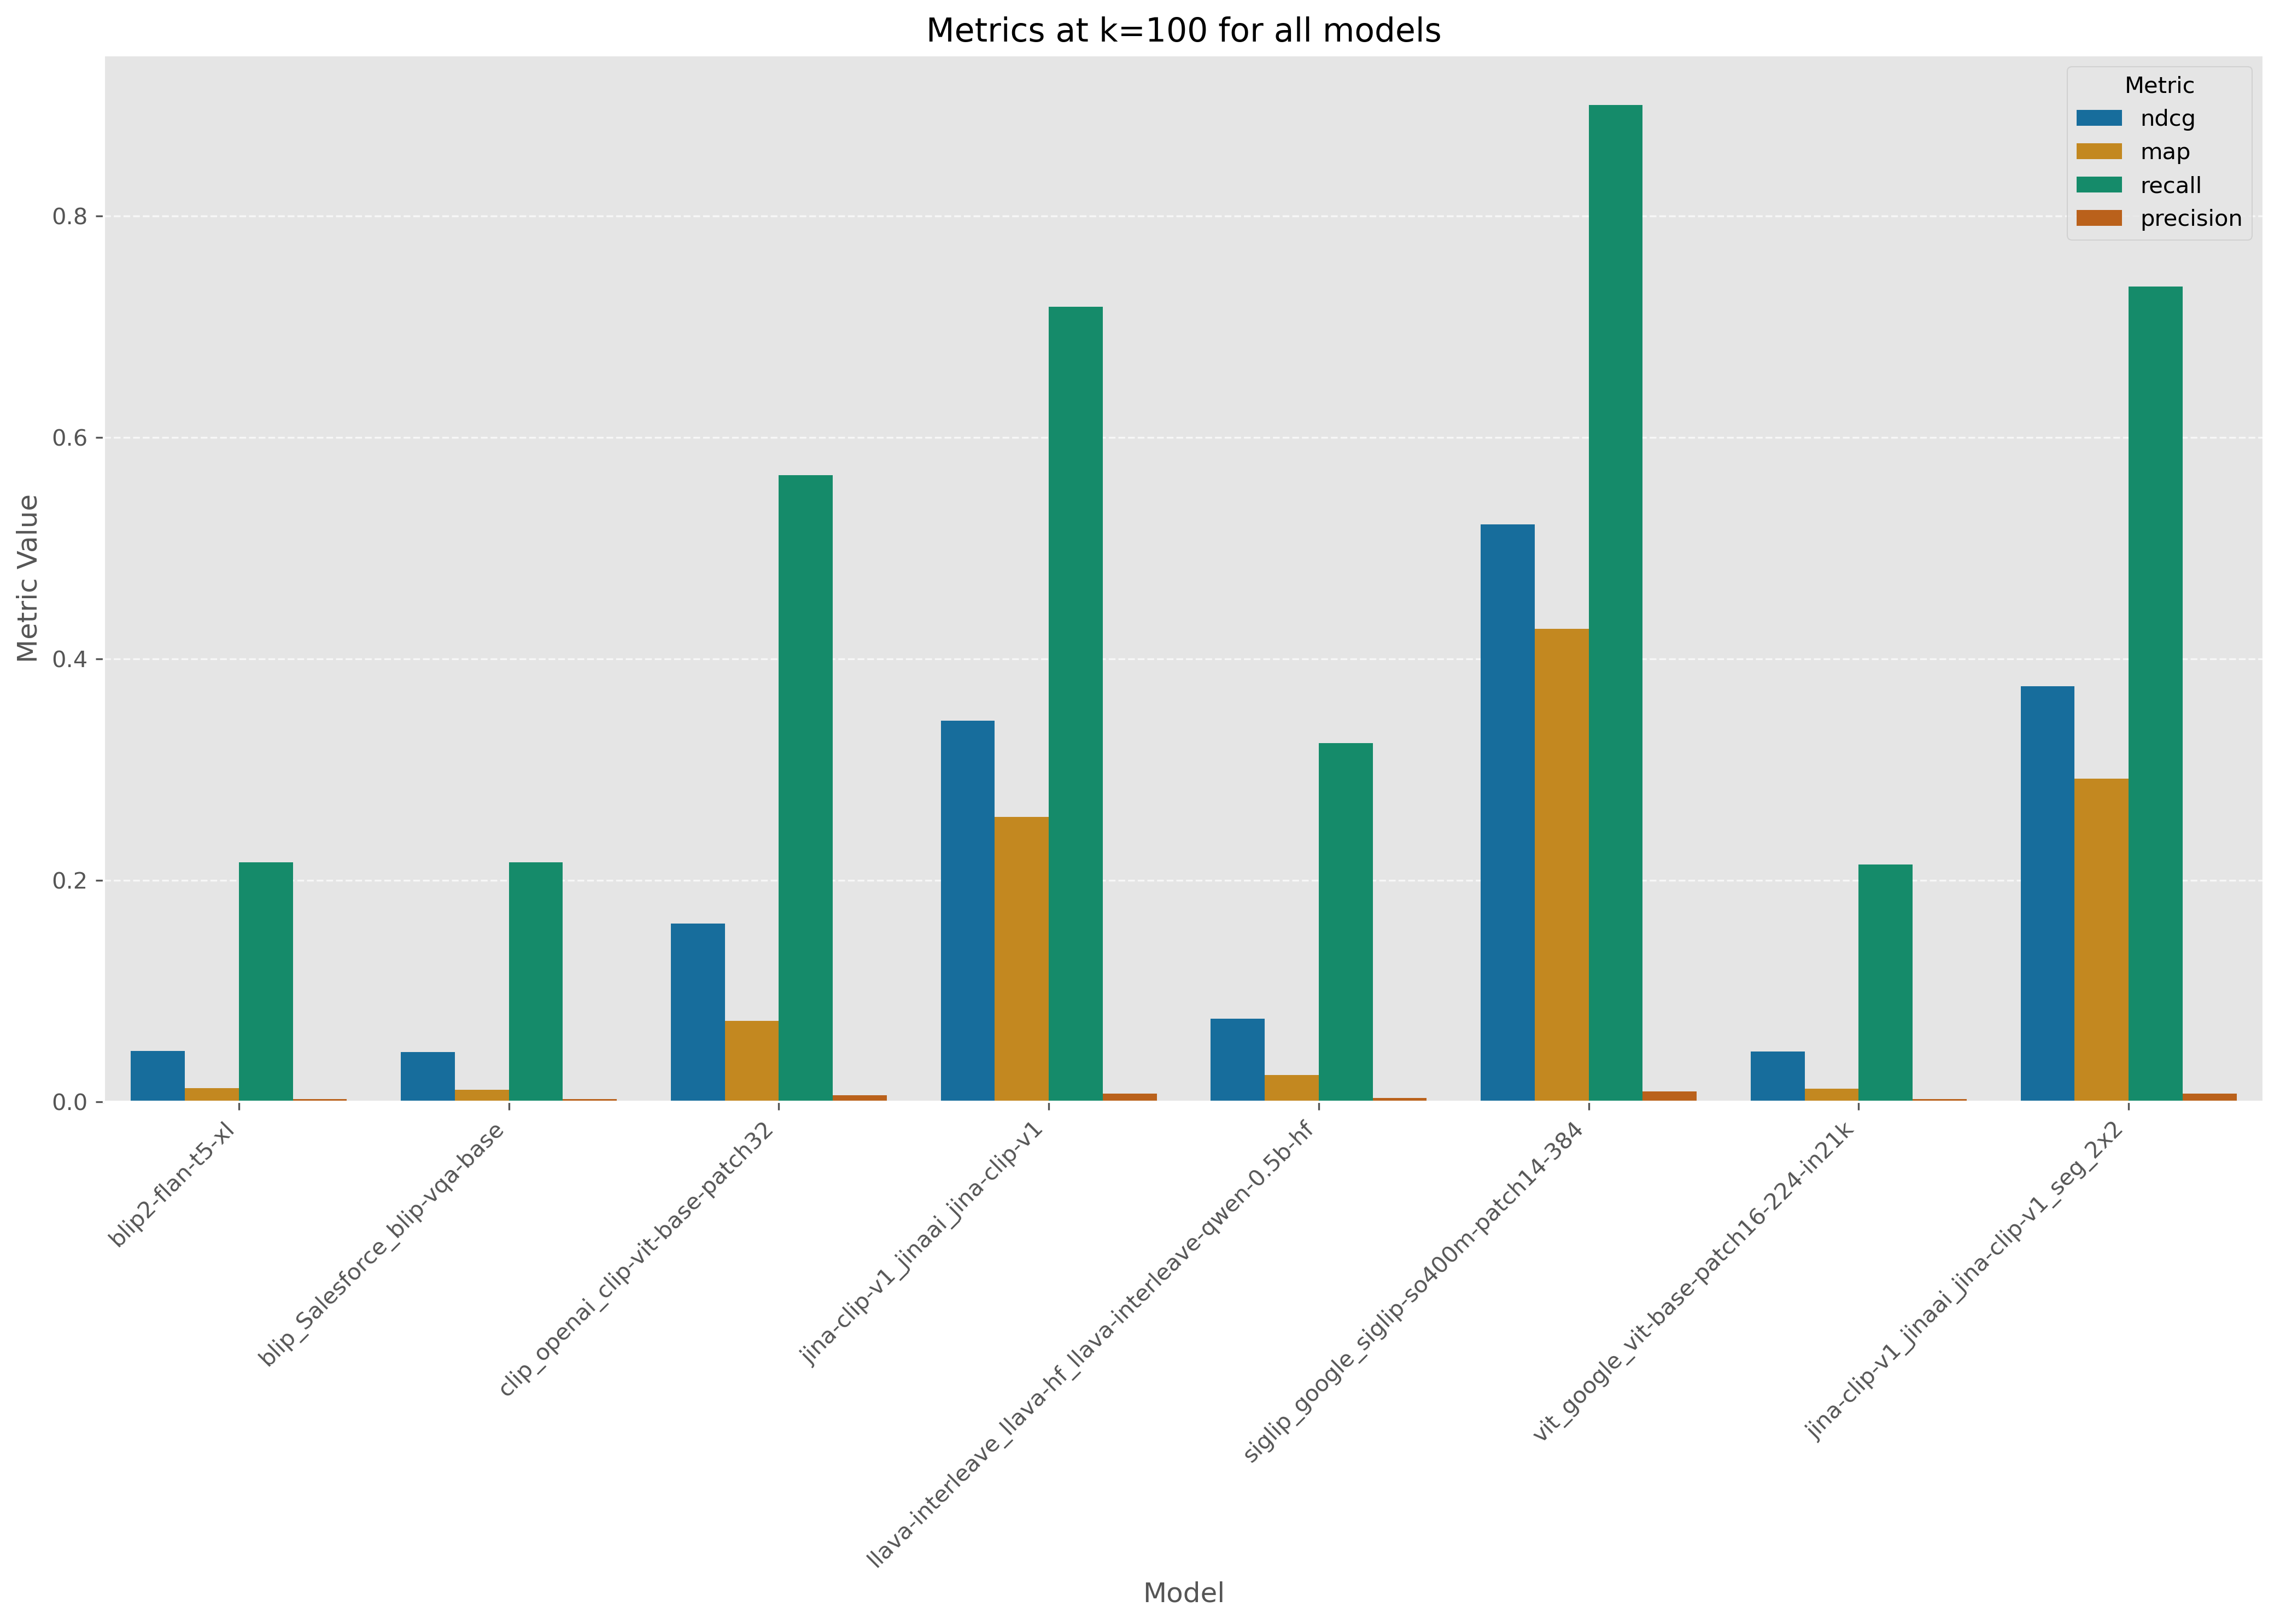

In [12]:
# Compare all metrics at k=10 and k=100
compare_at_k(metrics_df, 10)
compare_at_k(metrics_df, 100)

## Heatmap comparison of models

In [13]:
# Create a pivot table for each metric type
def create_heatmap(df, metric_name):
    # Filter the dataframe for the specific metric
    filtered_df = df[df['Metric'] == metric_name]
    
    # Create pivot table with models as rows and k values as columns
    pivot_df = filtered_df.pivot(index='Model', columns='k', values='Value')
    
    # Plot heatmap
    plt.figure(figsize=(12, len(pivot_df) * 0.8), dpi=300)
    sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".4f", linewidths=.5)
    plt.title(f'{metric_name.upper()} across different k values')
    plt.xlabel('k (cutoff)')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()

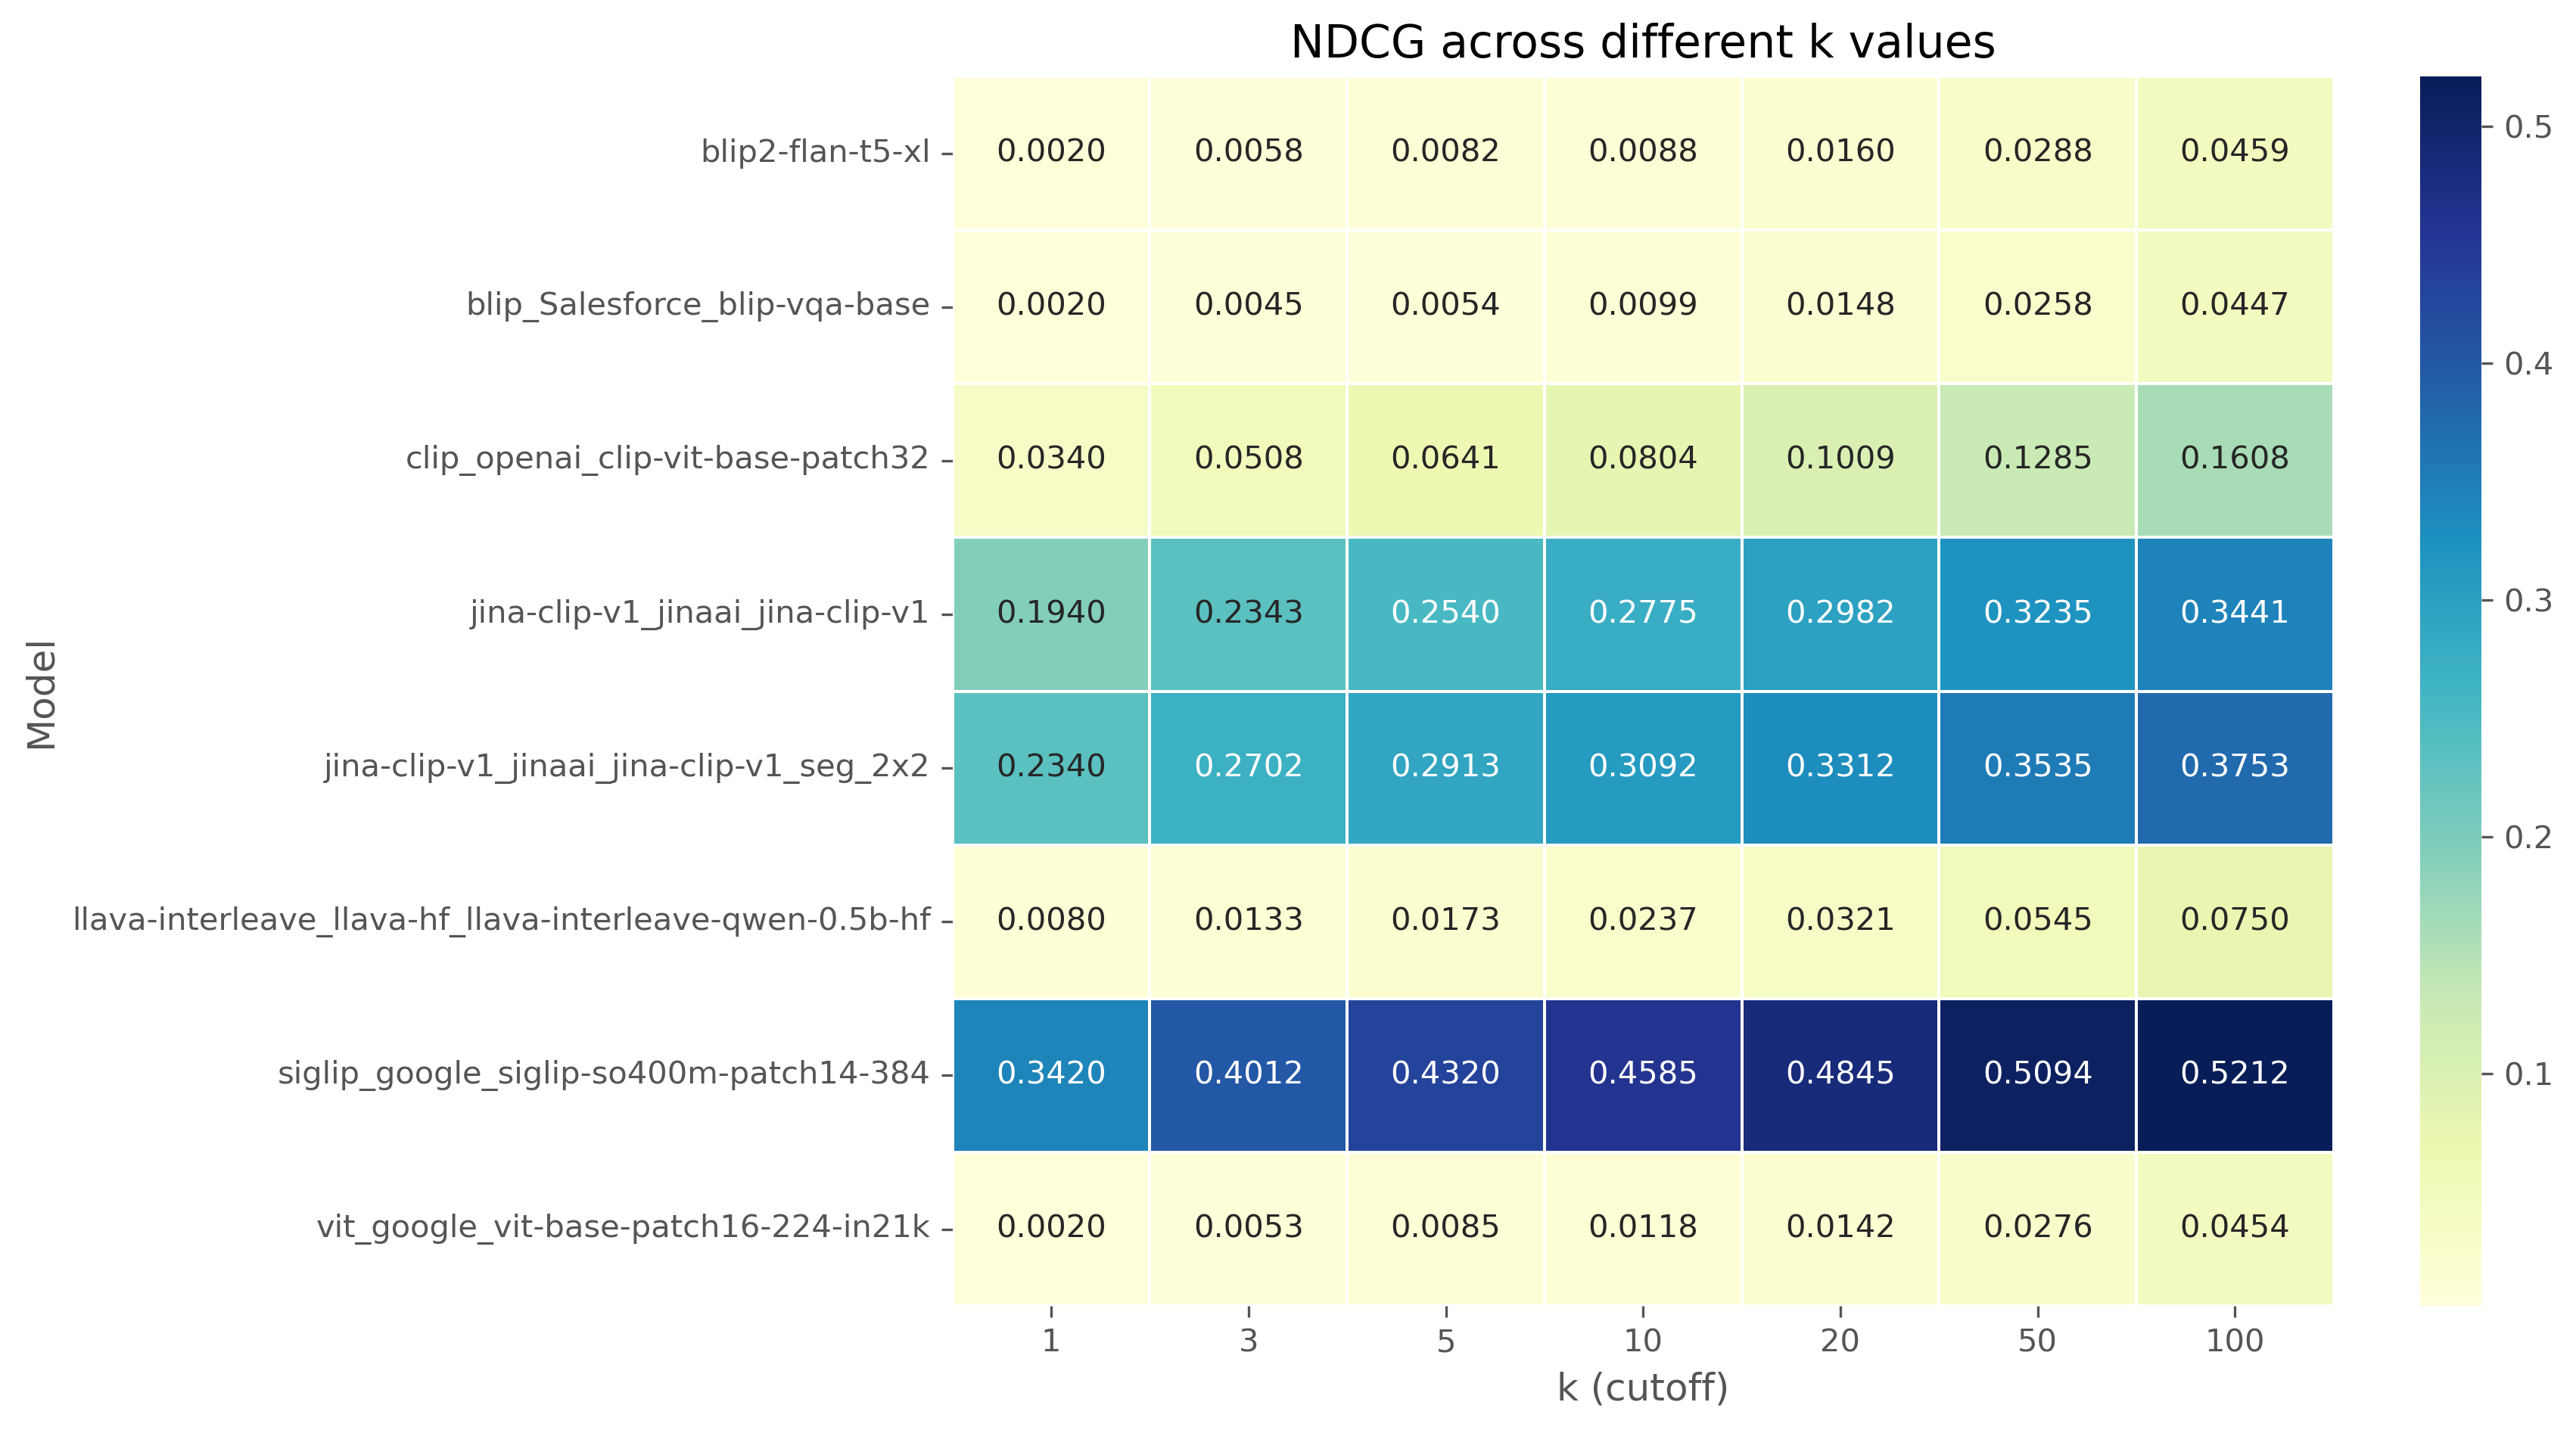

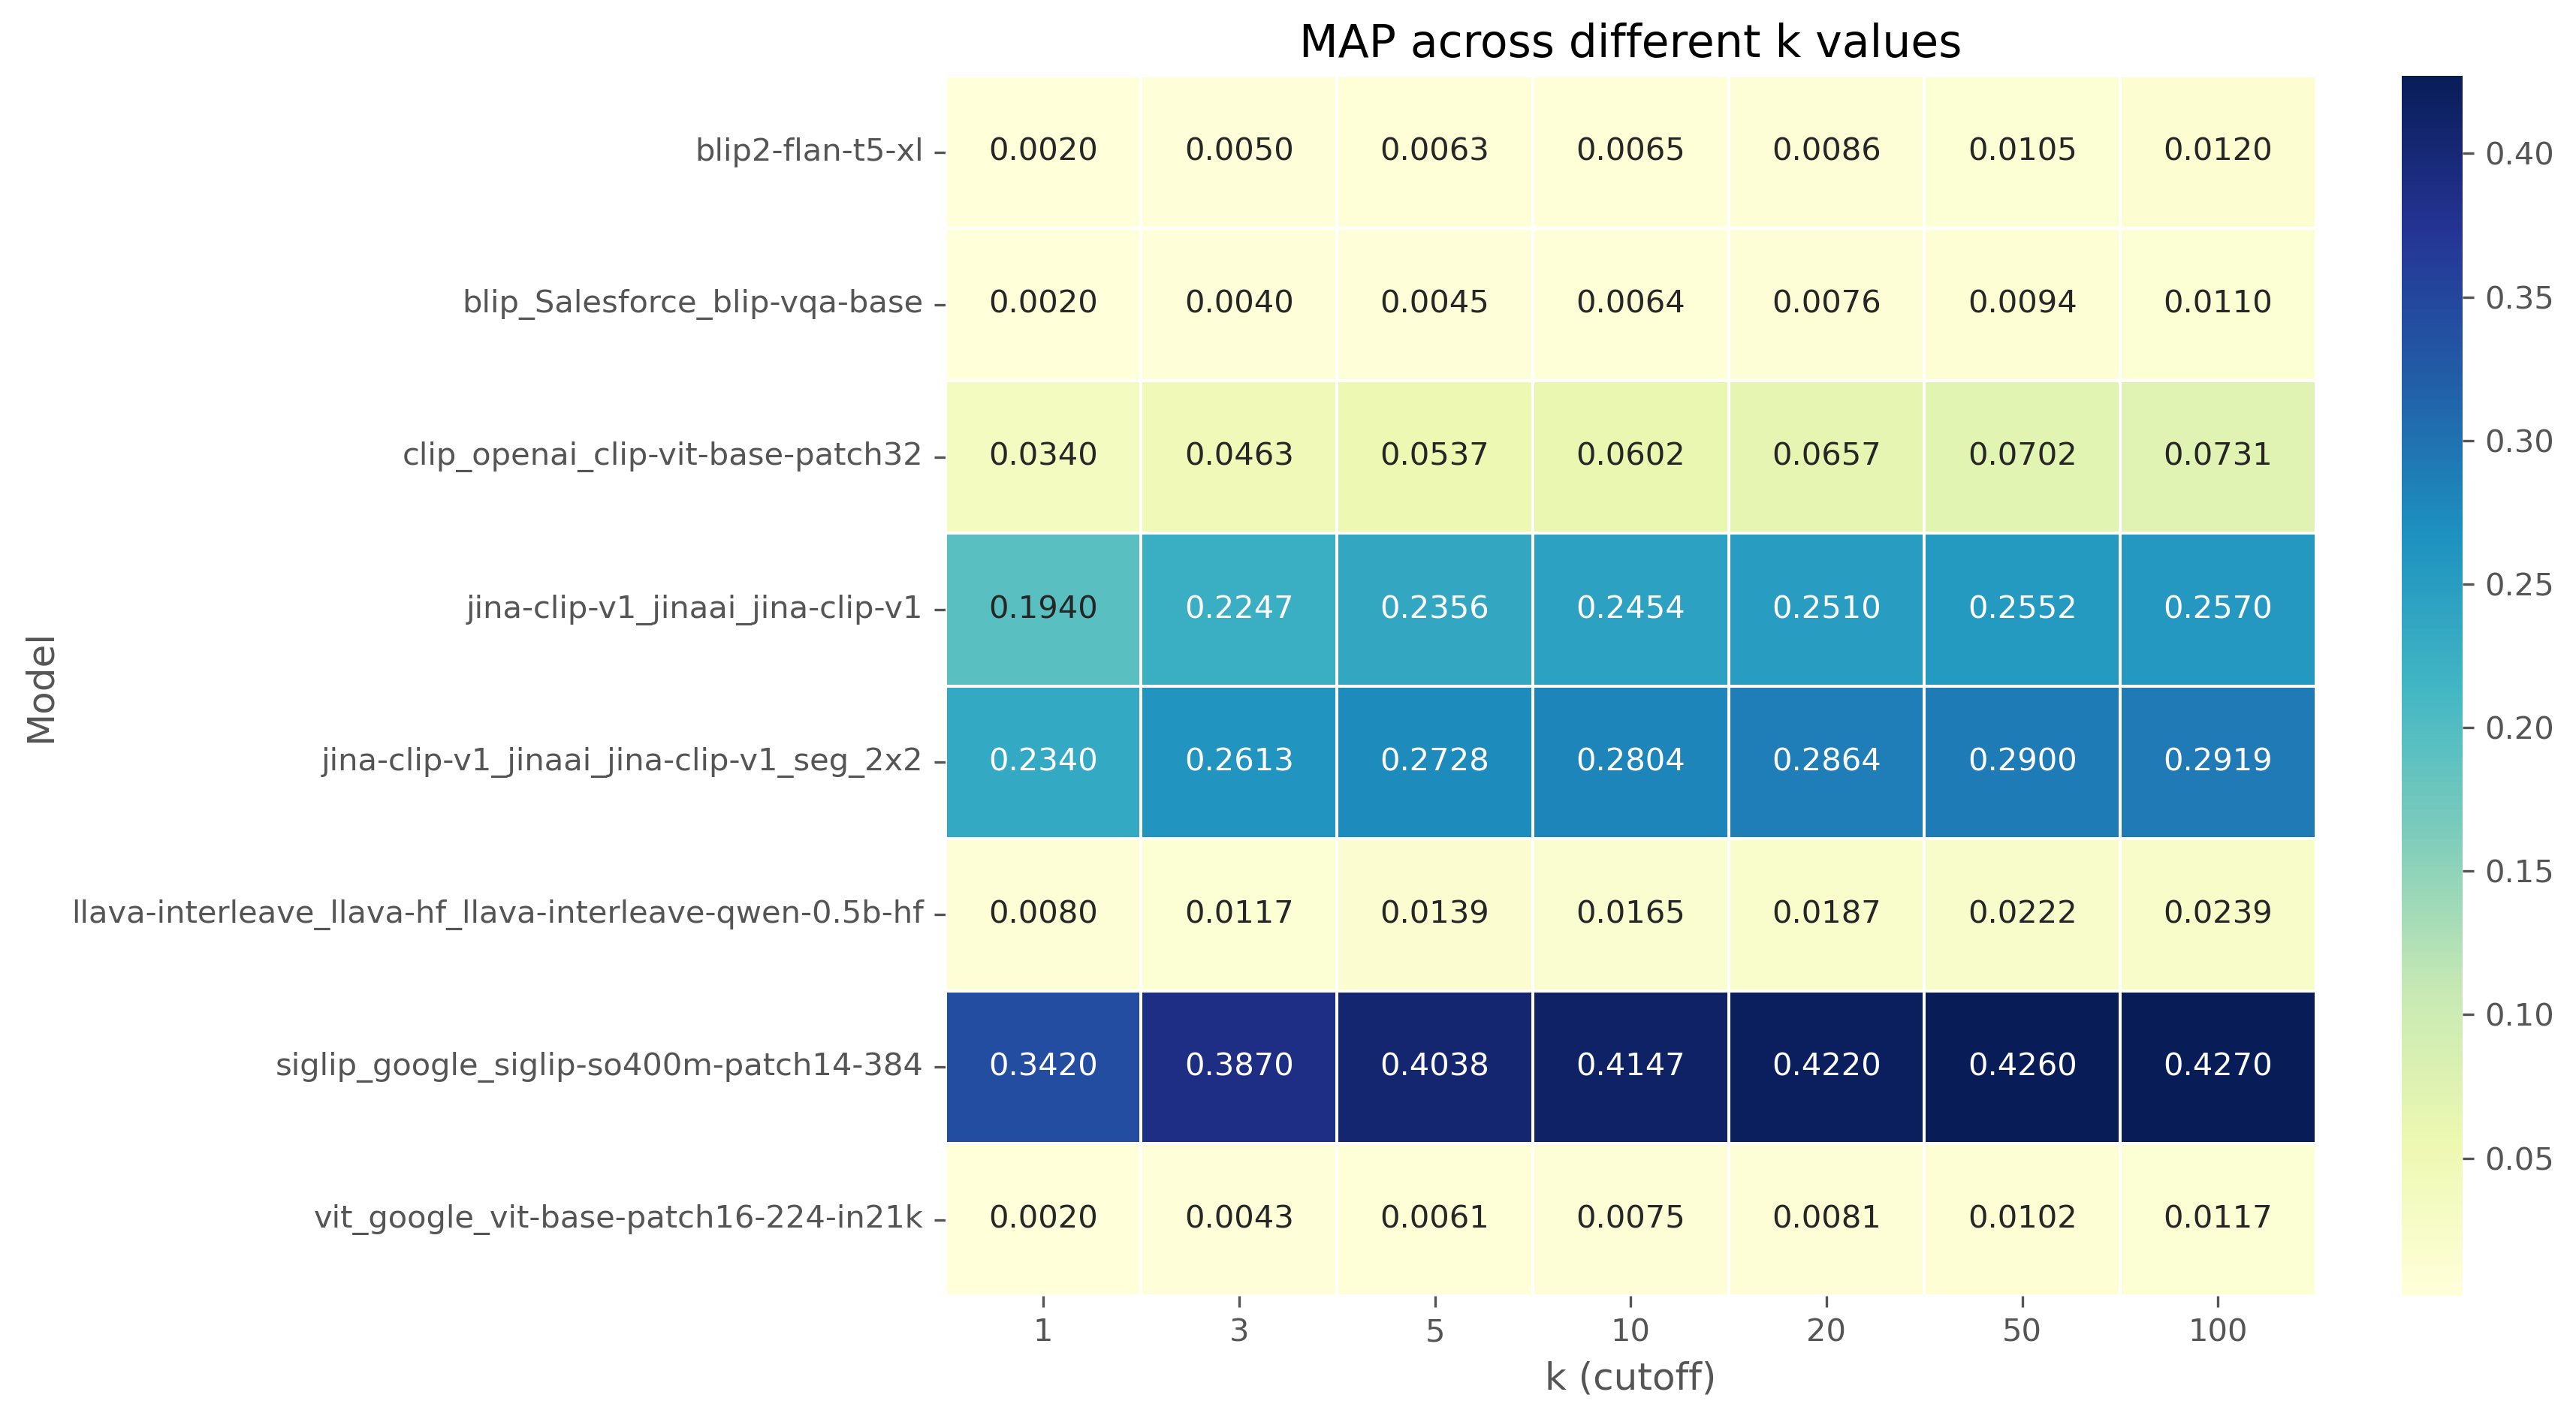

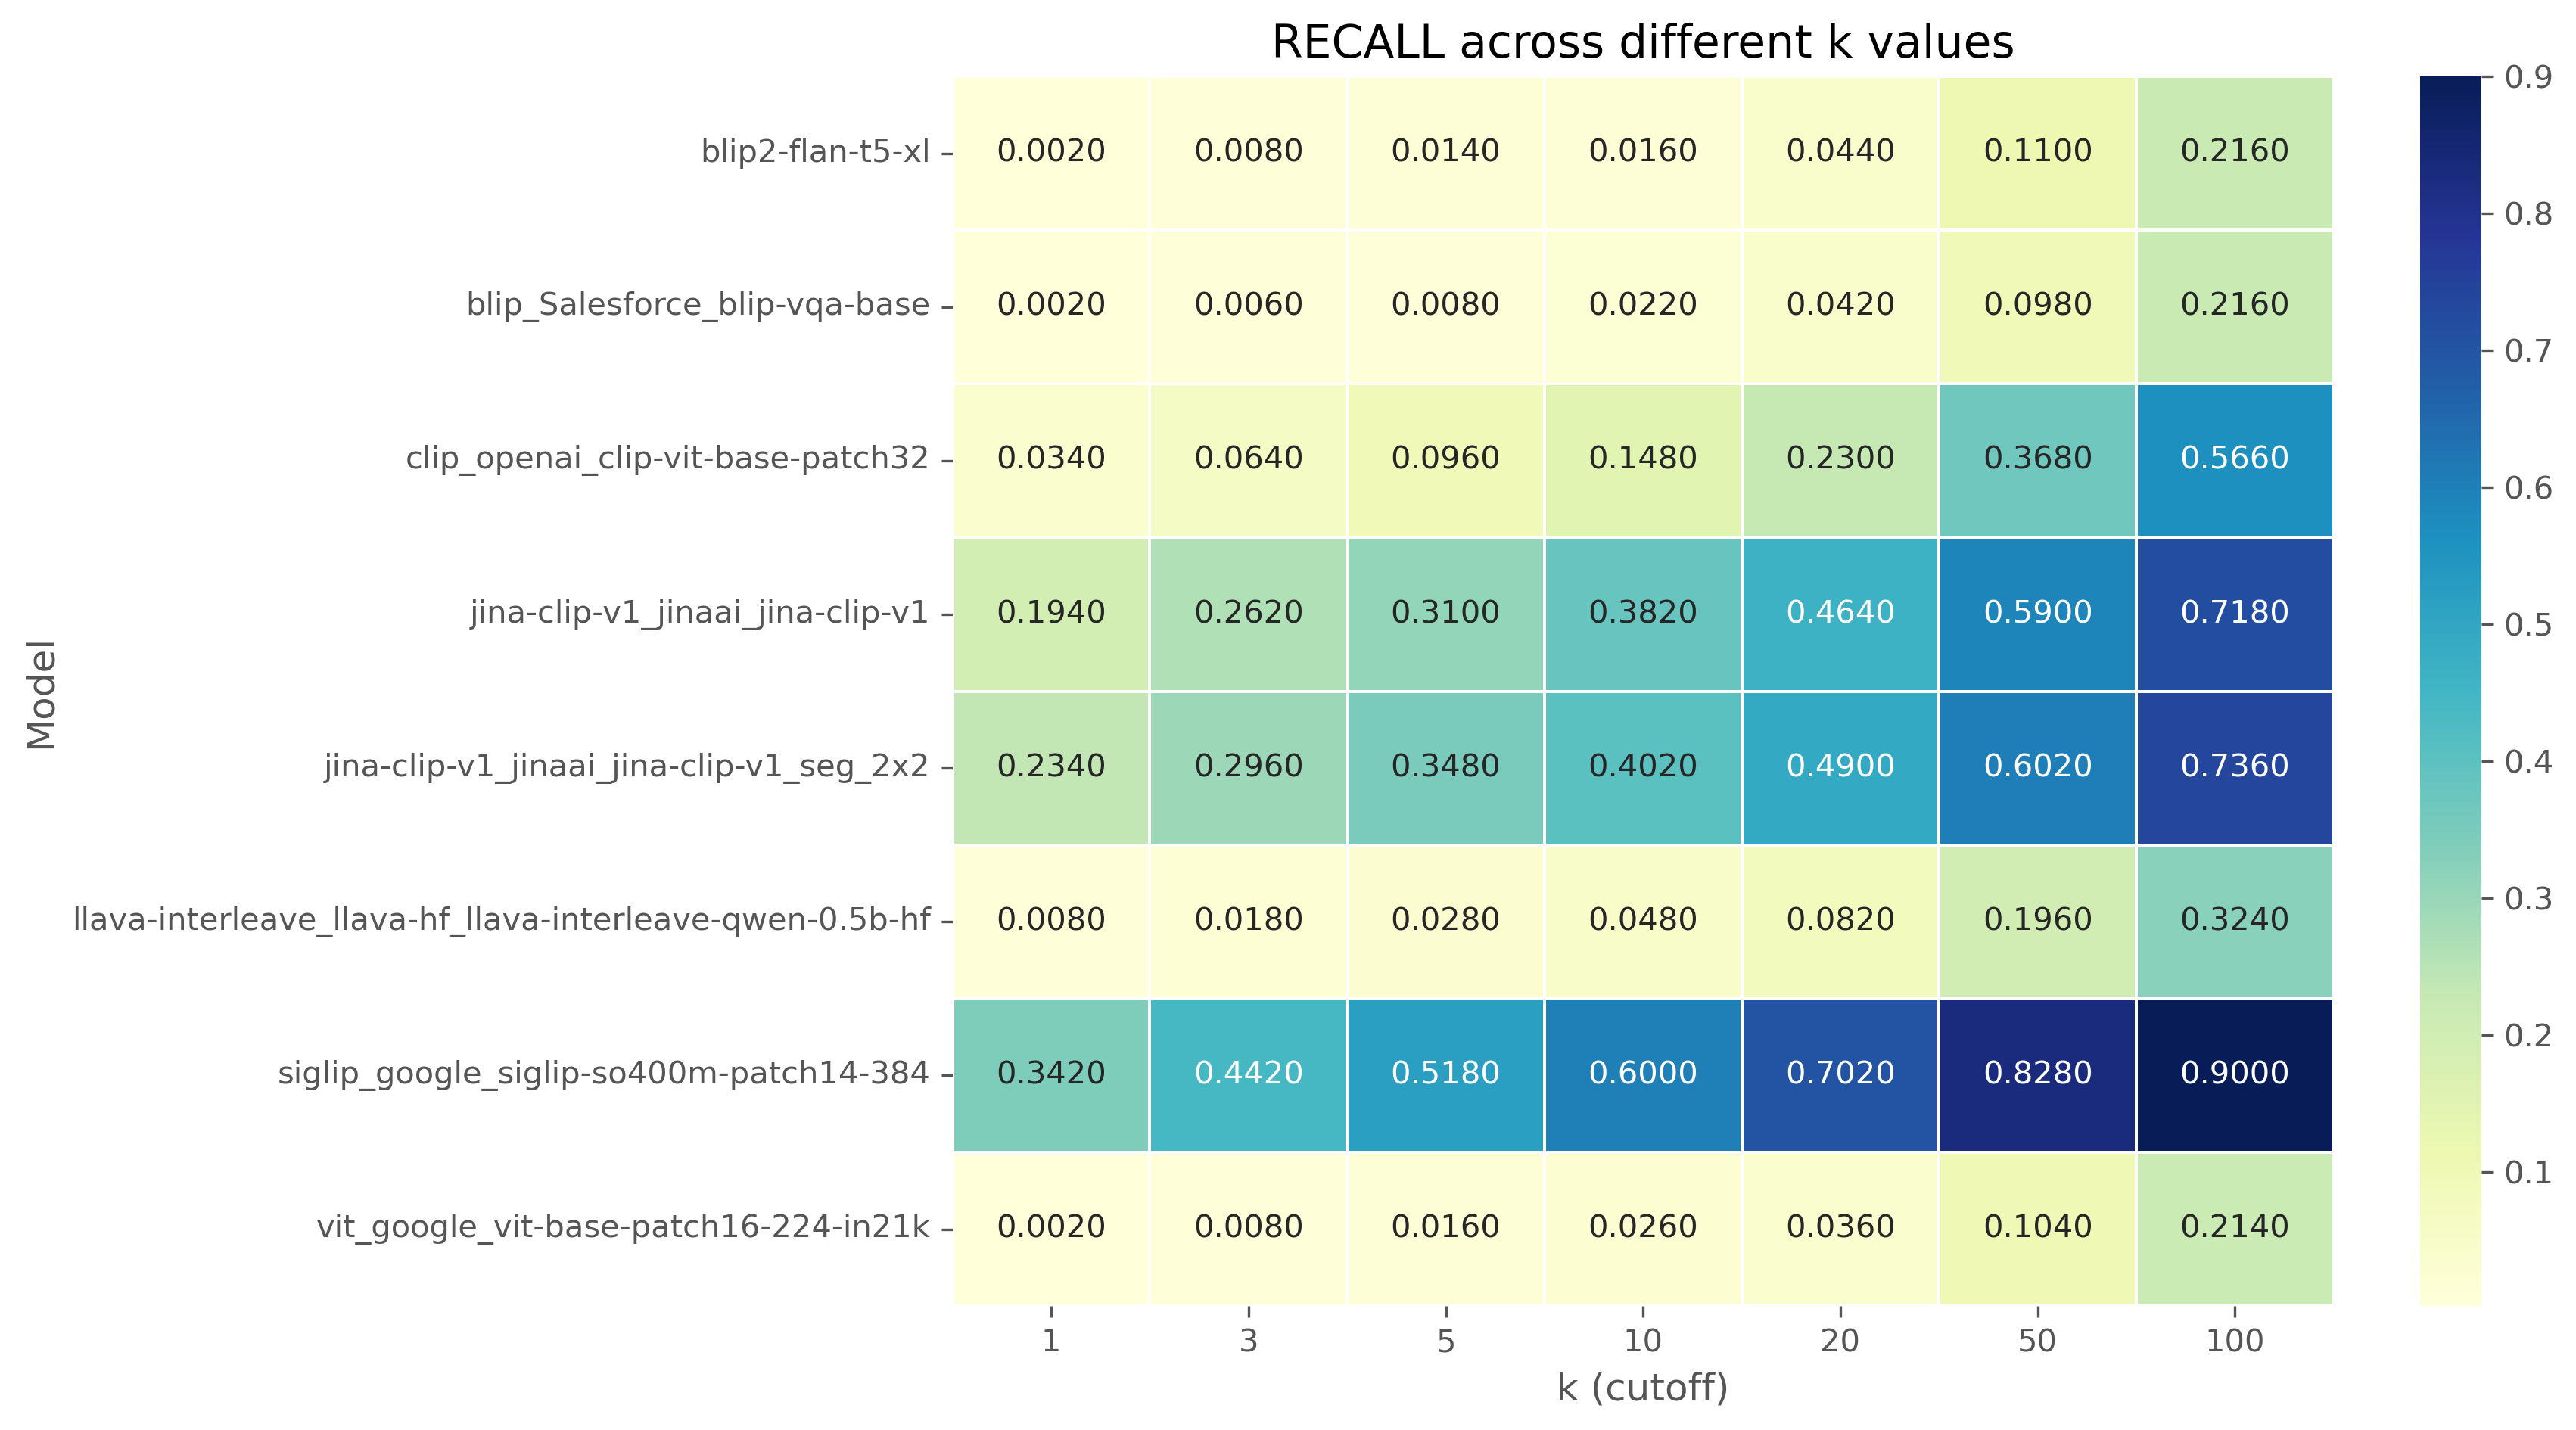

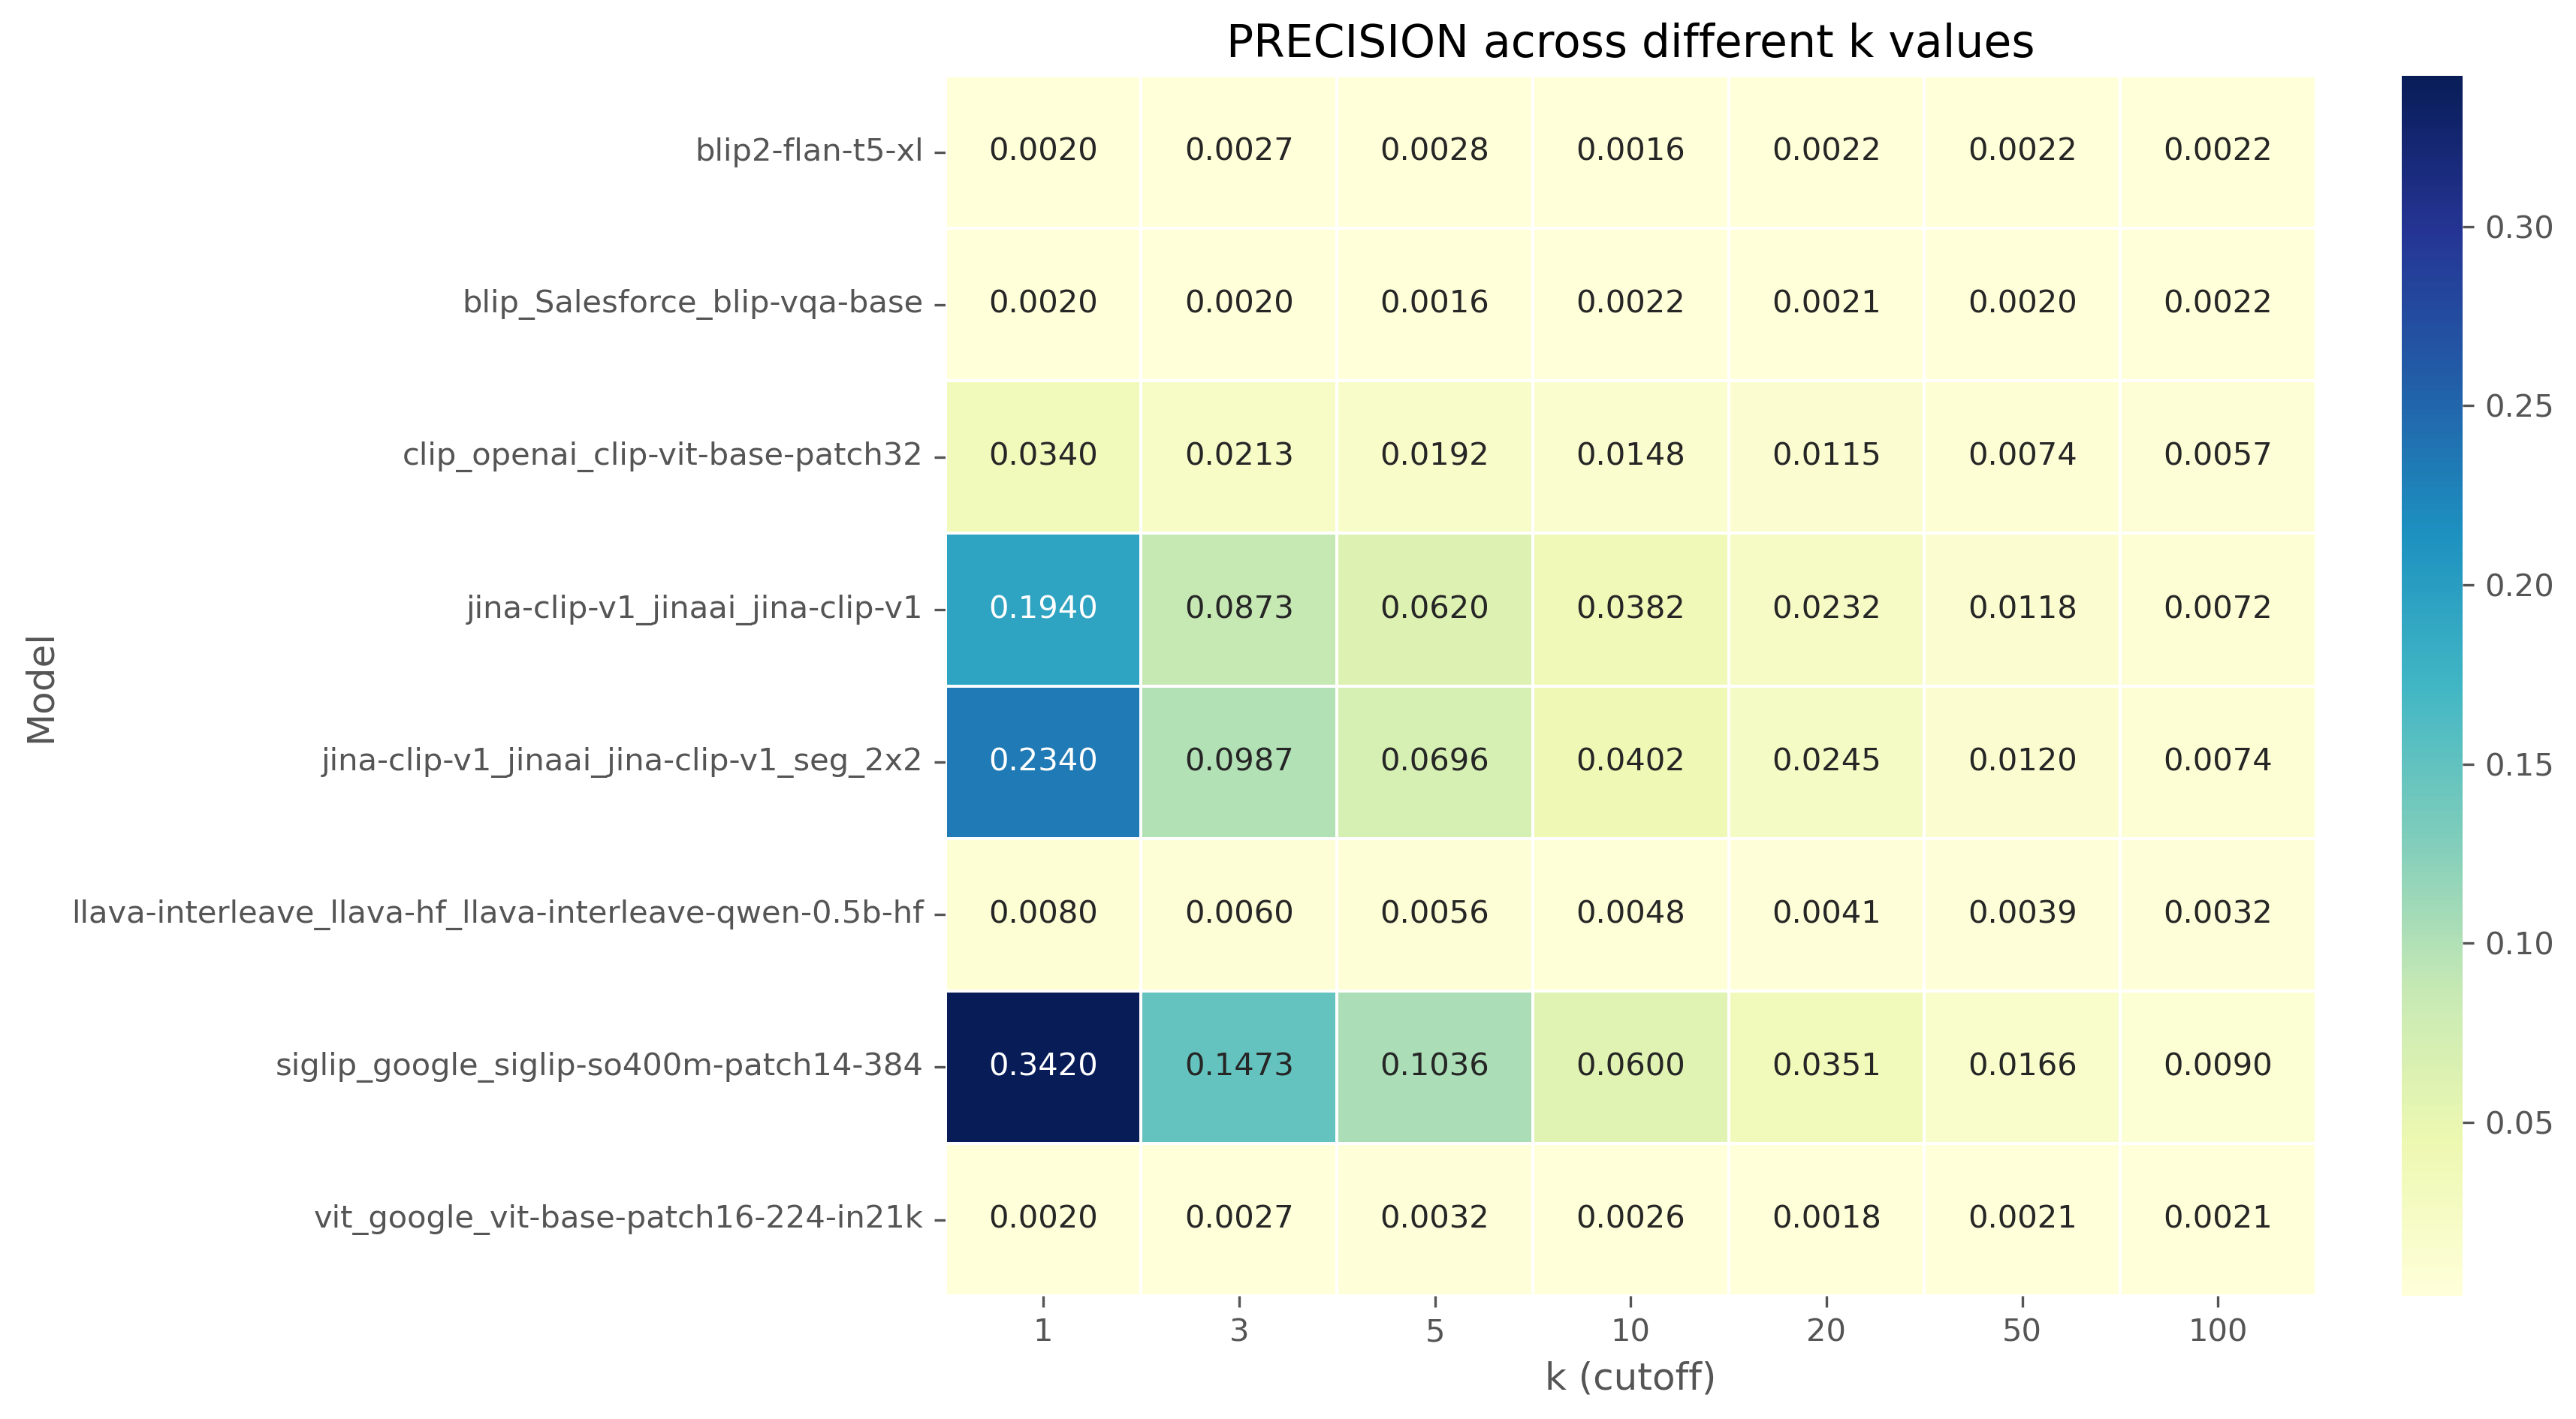

In [14]:
# Create heatmaps for each metric type
for metric in metric_types:
    create_heatmap(metrics_df, metric)

## Performance summary

In [15]:
# Create a summary table of the best performing model for each metric and k value
summary = []

for metric in metric_types:
    for k in k_values:
        filtered = metrics_df[(metrics_df['Metric'] == metric) & (metrics_df['k'] == k)]
        best_model = filtered.loc[filtered['Value'].idxmax()]
        summary.append({
            'Metric': metric,
            'k': k,
            'Best Model': best_model['Model'],
            'Best Value': best_model['Value']
        })

summary_df = pd.DataFrame(summary)
summary_df

Metric    k                               Best Model  Best Value
0        ndcg    1  siglip_google_siglip-so400m-patch14-384     0.34200
1        ndcg    3  siglip_google_siglip-so400m-patch14-384     0.40117
2        ndcg    5  siglip_google_siglip-so400m-patch14-384     0.43197
3        ndcg   10  siglip_google_siglip-so400m-patch14-384     0.45845
4        ndcg   20  siglip_google_siglip-so400m-patch14-384     0.48453
5        ndcg   50  siglip_google_siglip-so400m-patch14-384     0.50942
6        ndcg  100  siglip_google_siglip-so400m-patch14-384     0.52117
7         map    1  siglip_google_siglip-so400m-patch14-384     0.34200
8         map    3  siglip_google_siglip-so400m-patch14-384     0.38700
9         map    5  siglip_google_siglip-so400m-patch14-384     0.40380
10        map   10  siglip_google_siglip-so400m-patch14-384     0.41470
11        map   20  siglip_google_siglip-so400m-patch14-384     0.42202
12        map   50  siglip_google_siglip-so400m-patch14-384     0.42596
13        map  100  siglip_google_siglip-so400m-patch14-384     0.42702
14     recall    1  siglip_google_siglip-so400m-patch14-384     0.34200
15     recall    3  siglip_google_siglip-so400m-patch14-384     0.44200
16     recall    5  siglip_google_siglip-so400m-patch14-384     0.51800
17     recall   10  siglip_google_siglip-so400m-patch14-384     0.60000
18     recall   20  siglip_google_siglip-so400m-patch14-384     0.70200
19     recall   50  siglip_google_siglip-so400m-patch14-384     0.82800
20     recall  100  siglip_google_siglip-so400m-patch14-384     0.90000
21  precision    1  siglip_google_siglip-so400m-patch14-384     0.34200
22  precision    3  siglip_google_siglip-so400m-patch14-384     0.14733
23  precision    5  siglip_google_siglip-so400m-patch14-384     0.10360
24  precision   10  siglip_google_siglip-so400m-patch14-384     0.06000
25  precision   20  siglip_google_siglip-so400m-patch14-384     0.03510
26  precision   50  siglip_google_siglip-so400m-patch14-384     0.01656
27  precision  100  siglip_google_siglip-so400m-patch14-384     0.00900

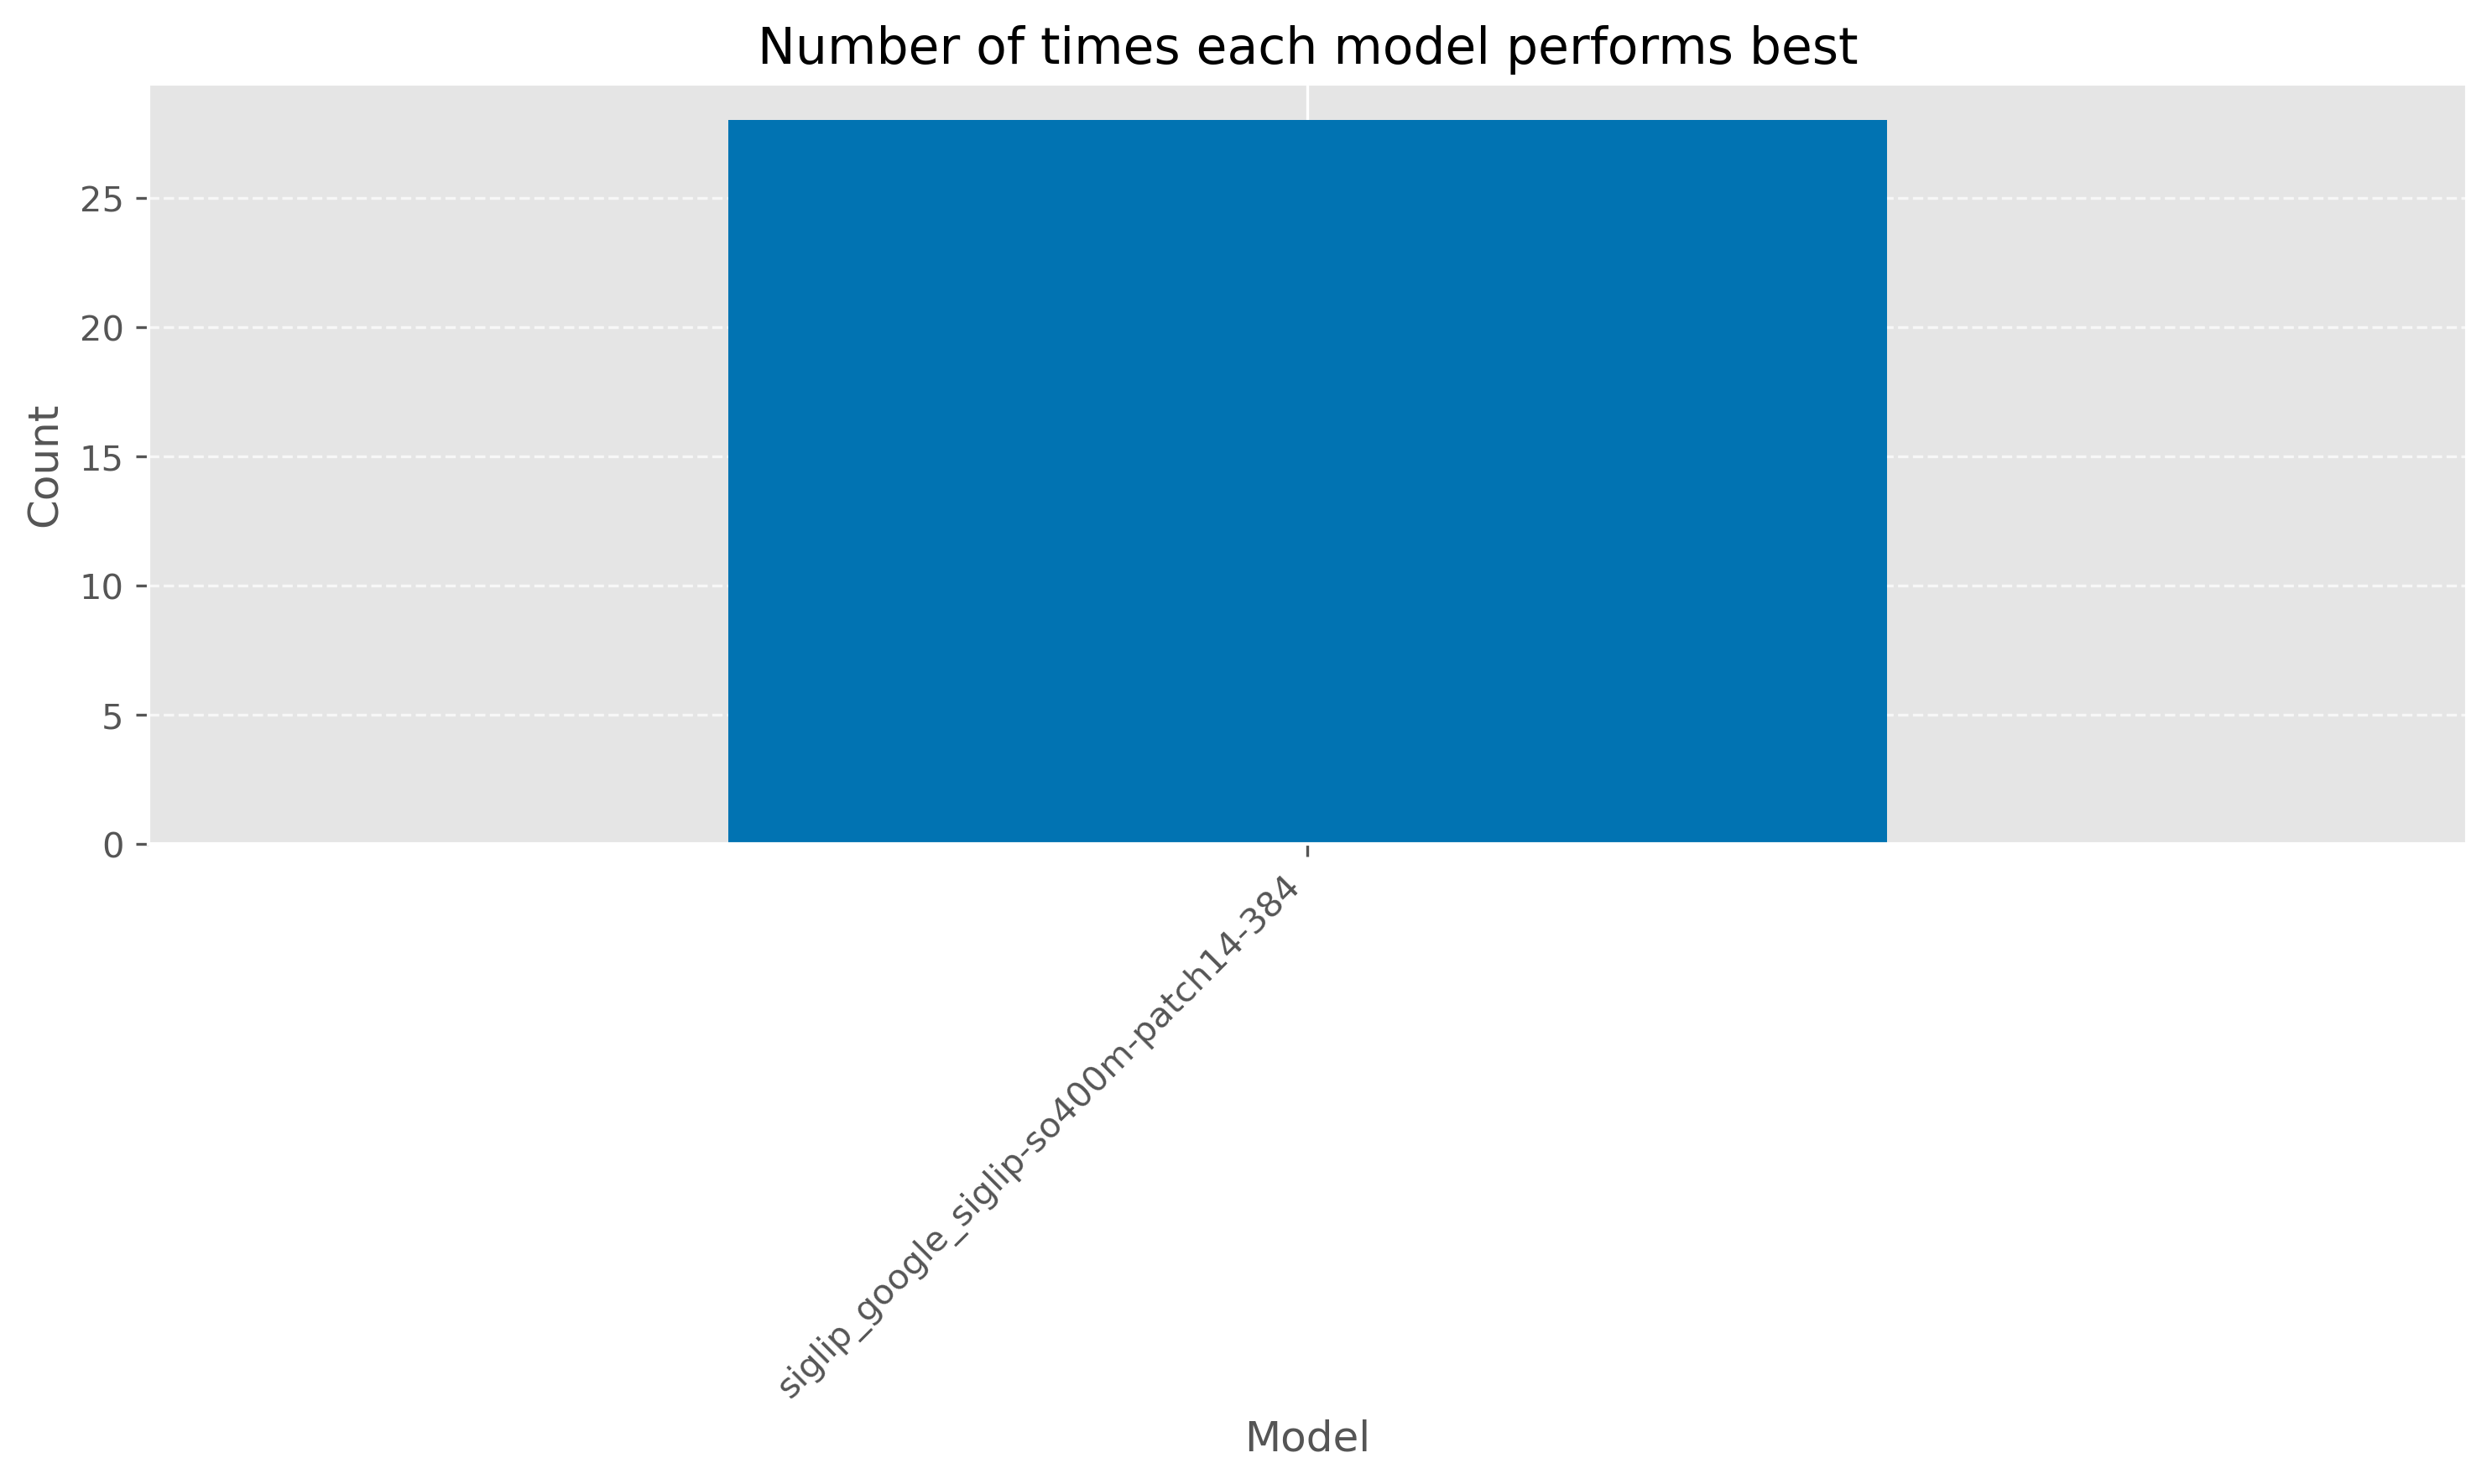

In [16]:
# Count how many times each model is the best
best_model_counts = summary_df['Best Model'].value_counts()

plt.figure(figsize=(10, 6), dpi=300)
best_model_counts.plot(kind='bar')
plt.title('Number of times each model performs best')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Comparison of Normal vs. Segmented Image Input

This section compares the performance of models when using normal vs. segmented image input.

In [17]:
# Identify normal and segmented versions of the same model
def extract_base_model_name(model_name):
    # Remove segmentation information to get base model name
    return re.sub(r'_seg_\d+x\d+(?:_overlap_\d+)?$', '', model_name)

# Group models by their base name
model_groups = {}
for model_name in model_metrics.keys():
    base_name = extract_base_model_name(model_name)
    if base_name not in model_groups:
        model_groups[base_name] = []
    model_groups[base_name].append(model_name)

# Filter to keep only models that have both normal and segmented versions
paired_models = {k: v for k, v in model_groups.items() if len(v) > 1}

print("Models with both normal and segmented versions:")
for base_name, variants in paired_models.items():
    pp({base_name: variants})

Models with both normal and segmented versions:
{'jina-clip-v1_jinaai_jina-clip-v1': ['jina-clip-v1_jinaai_jina-clip-v1',
                                      'jina-clip-v1_jinaai_jina-clip-v1_seg_2x2']}


In [18]:
# Function to create a DataFrame comparing normal vs segmented for a specific model
def create_model_comparison_df(base_model_name, model_variants):
    comparison_data = []
    
    for model_variant in model_variants:
        # Determine if this is a normal or segmented variant
        is_segmented = '_seg_' in model_variant
        variant_type = 'Segmented' if is_segmented else 'Normal'
        
        # Get segmentation details if available
        seg_info = ''
        if is_segmented:
            grid_match = re.search(r'_seg_(\d+x\d+)', model_variant)
            overlap_match = re.search(r'_overlap_(\d+)', model_variant)
            
            grid = grid_match.group(1) if grid_match else ''
            overlap = f", {overlap_match.group(1)}% overlap" if overlap_match else ''
            seg_info = f" ({grid}{overlap})"
        
        # Add the variant's metrics to the comparison data
        for metric_type in metric_types:
            for k in k_values:
                metric_key = f"{metric_type}_at_{k}"
                if metric_key in model_metrics[model_variant]:
                    comparison_data.append({
                        'Base Model': base_model_name,
                        'Variant': f"{variant_type}{seg_info}",
                        'Full Name': model_variant,
                        'Metric': metric_type,
                        'k': k,
                        'Value': model_metrics[model_variant][metric_key]
                    })
    
    return pd.DataFrame(comparison_data)

# Create comparison DataFrames for all paired models
model_comparison_dfs = {}
for base_name, variants in paired_models.items():
    model_comparison_dfs[base_name] = create_model_comparison_df(base_name, variants)

In [19]:
# Function to plot comparison of normal vs segmented for a specific model and metric
def plot_normal_vs_segmented(base_model_name, metric_name):
    if base_model_name not in model_comparison_dfs:
        print(f"No comparison data available for {base_model_name}")
        return
        
    df = model_comparison_dfs[base_model_name]
    metric_df = df[df['Metric'] == metric_name]
    
    plt.figure(figsize=(12, 6), dpi=300)
    sns.lineplot(data=metric_df, x='k', y='Value', hue='Variant', marker='o', markersize=8)
    
    plt.title(f'{metric_name.upper()} at k for {base_model_name}: Normal vs. Segmented')
    plt.xlabel('k (cutoff)')
    plt.ylabel(f'{metric_name.upper()} Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Input Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


## jina-clip-v1_jinaai_jina-clip-v1 - Normal vs. Segmented Comparison


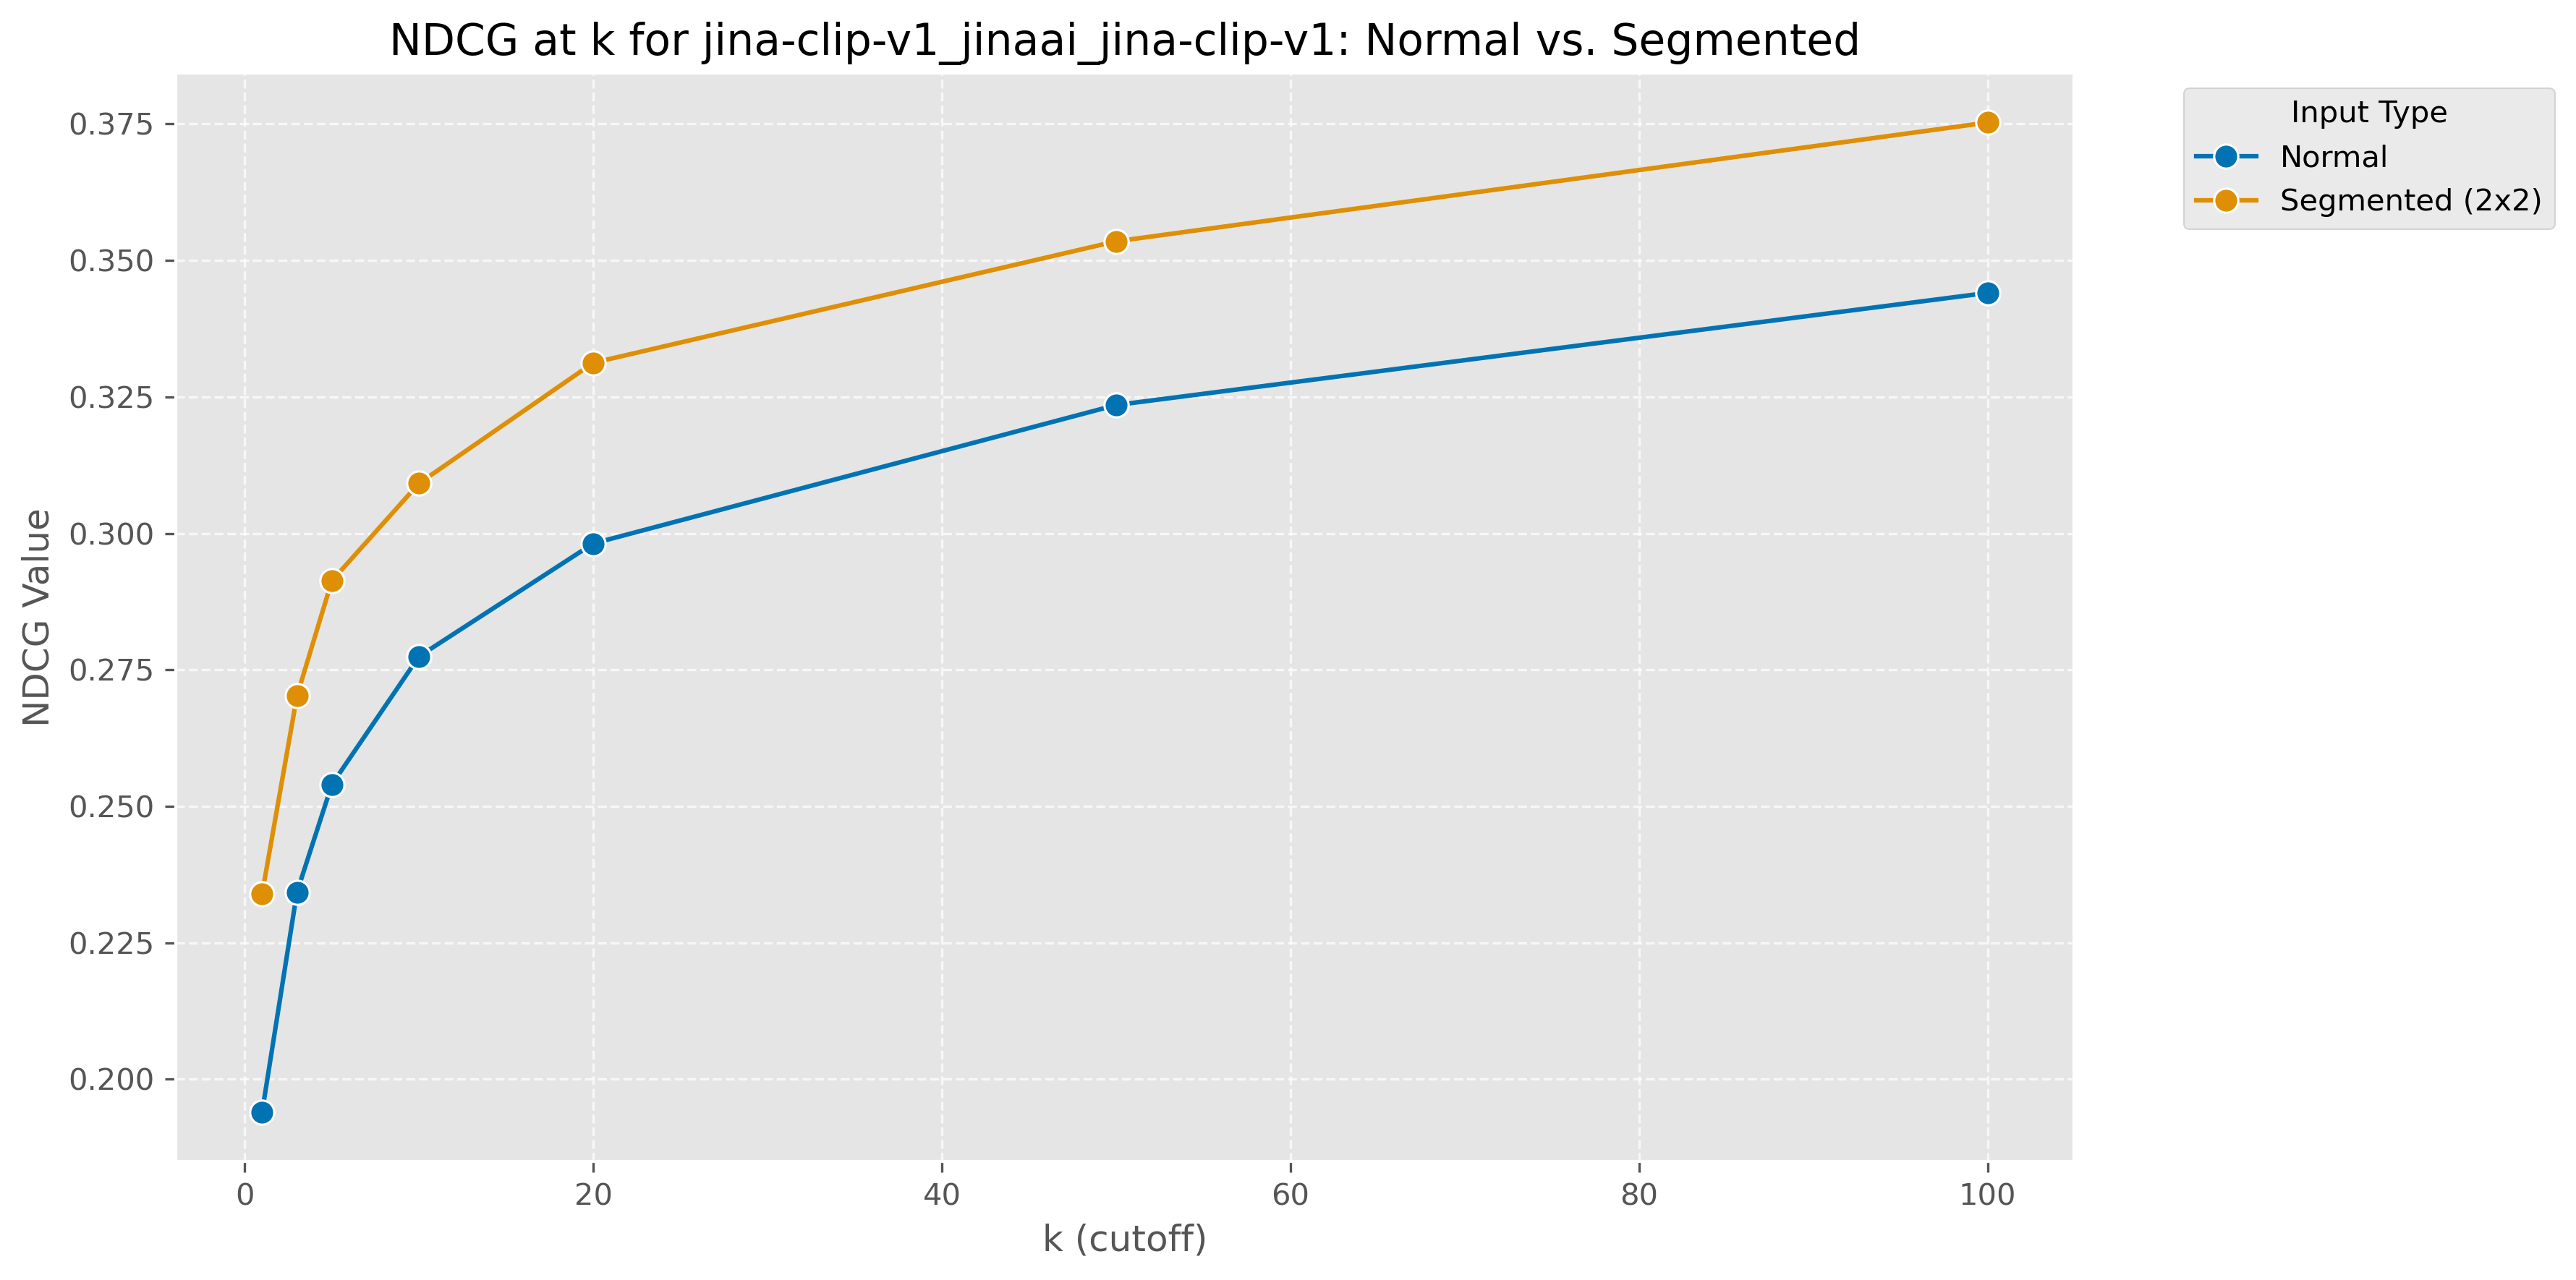

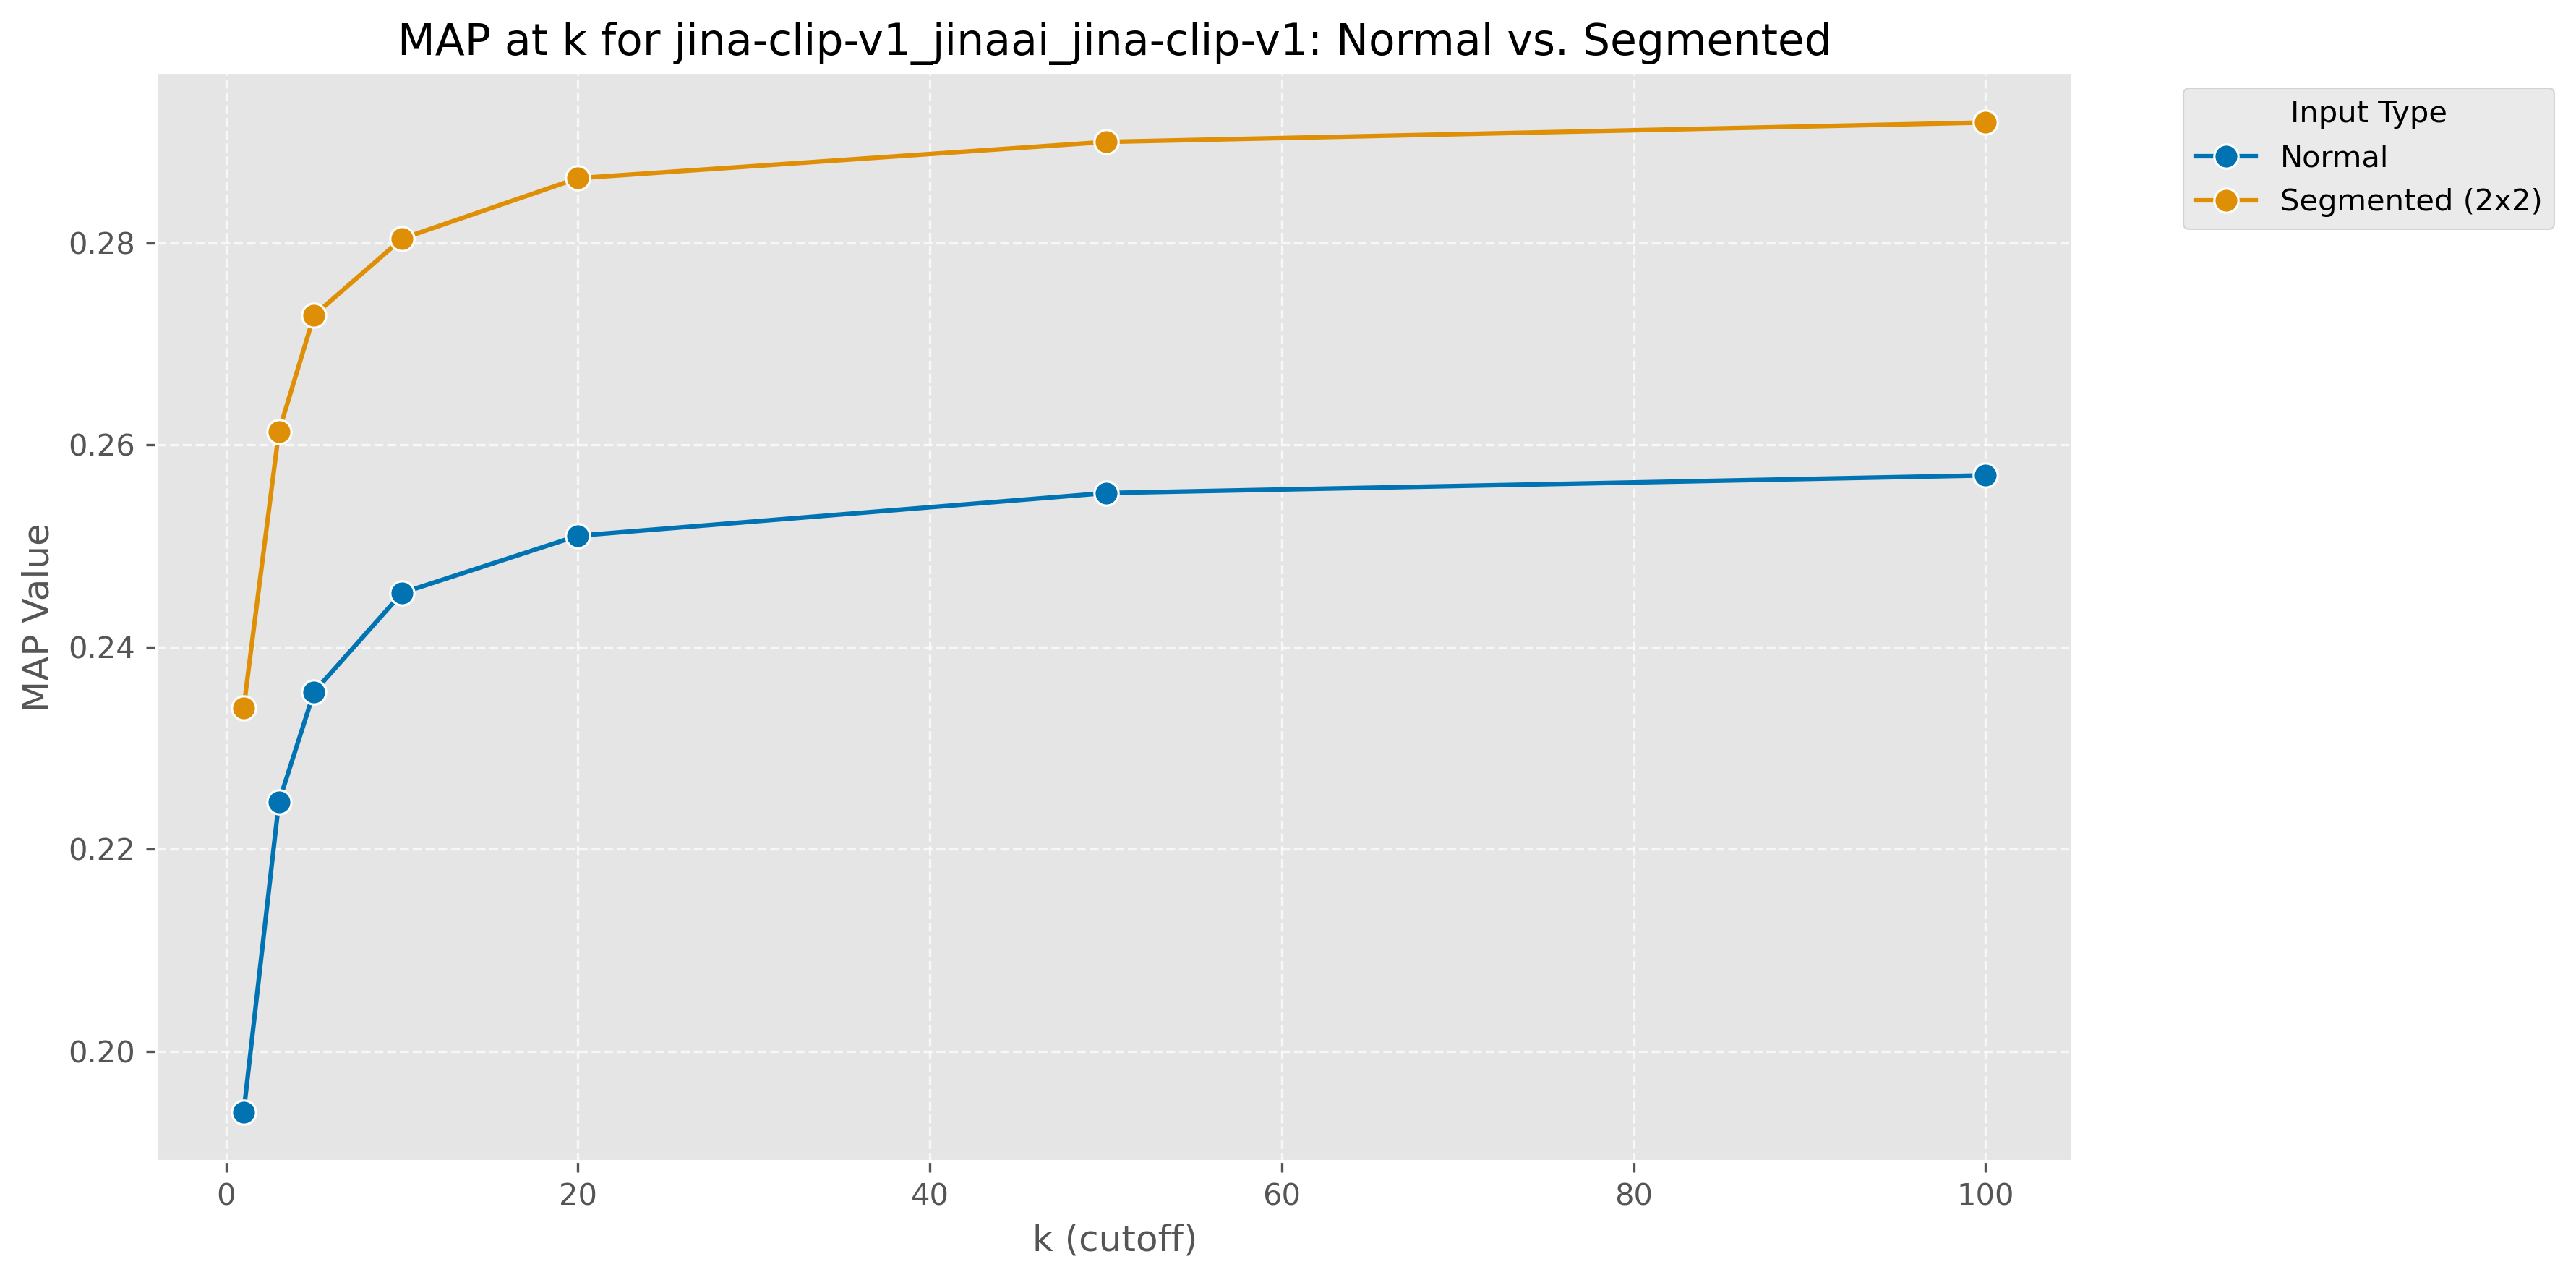

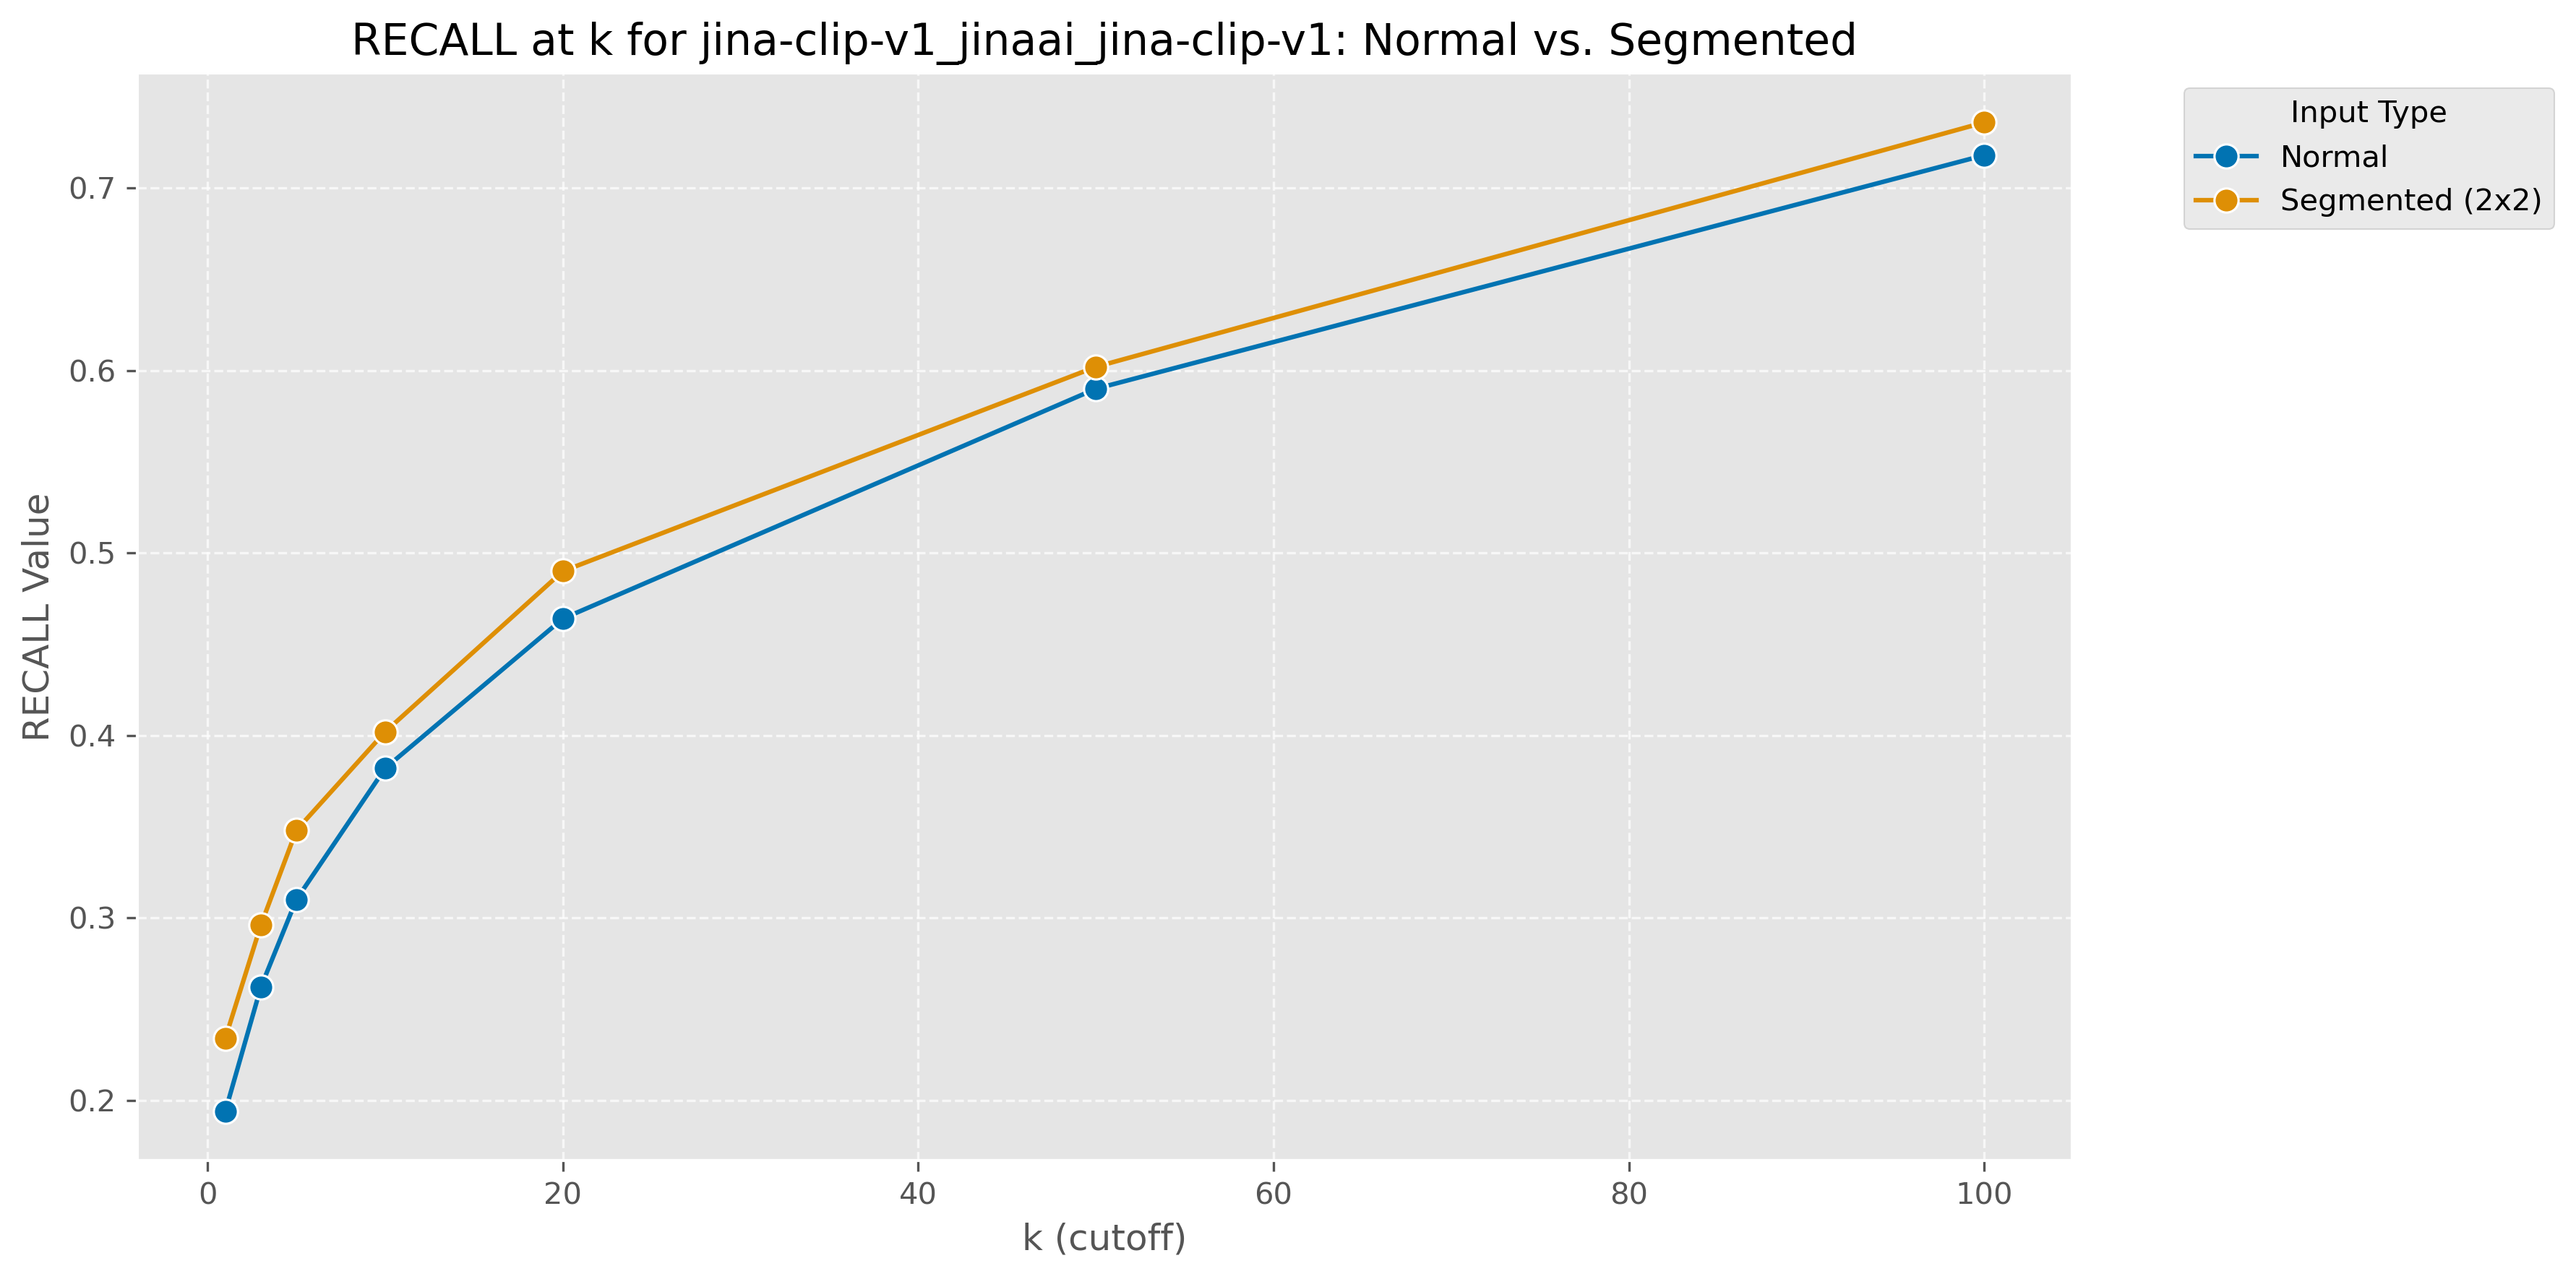

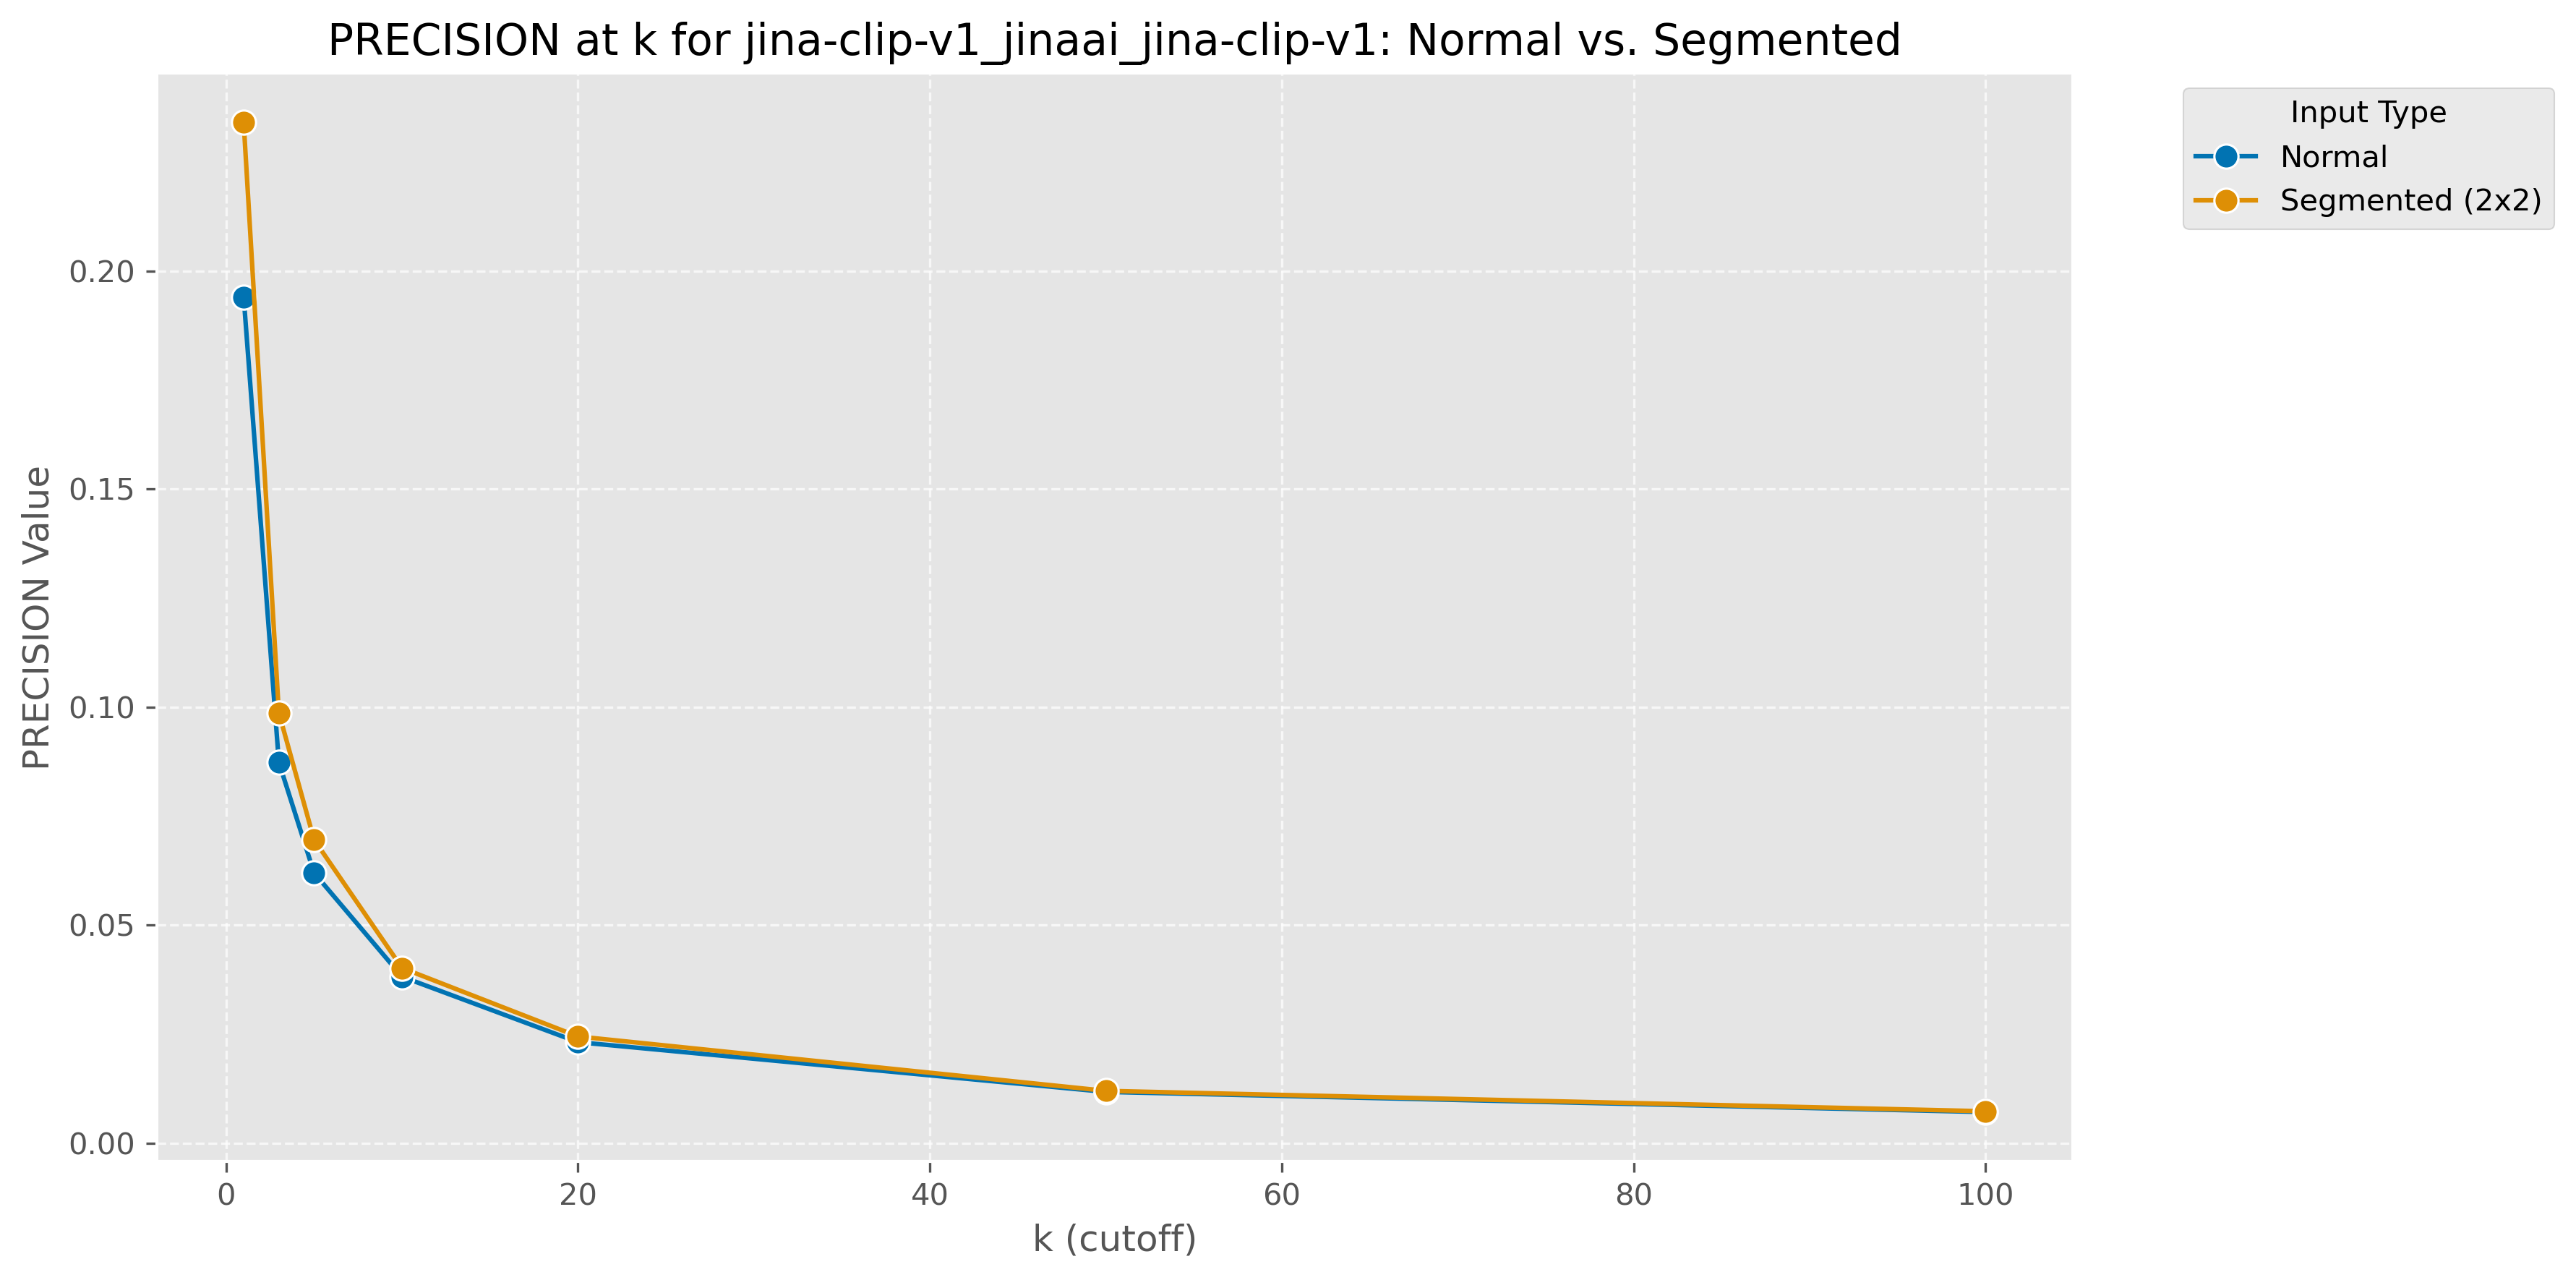

In [20]:
# Plot comparison for each paired model and metric
for base_model_name in paired_models.keys():
    print(f"\n## {base_model_name} - Normal vs. Segmented Comparison")
    for metric in metric_types:
        plot_normal_vs_segmented(base_model_name, metric)

In [21]:
# Function to create a comparison bar chart at a specific k value
def compare_normal_vs_segmented_at_k(base_model_name, k_value):
    if base_model_name not in model_comparison_dfs:
        print(f"No comparison data available for {base_model_name}")
        return
        
    df = model_comparison_dfs[base_model_name]
    k_df = df[df['k'] == k_value]
    
    plt.figure(figsize=(14, 6), dpi=300)
    sns.barplot(data=k_df, x='Metric', y='Value', hue='Variant')
    
    plt.title(f'{base_model_name}: Normal vs. Segmented comparison at k={k_value}')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Input Type')
    plt.tight_layout()
    plt.show()


## jina-clip-v1_jinaai_jina-clip-v1 - Performance at specific k values


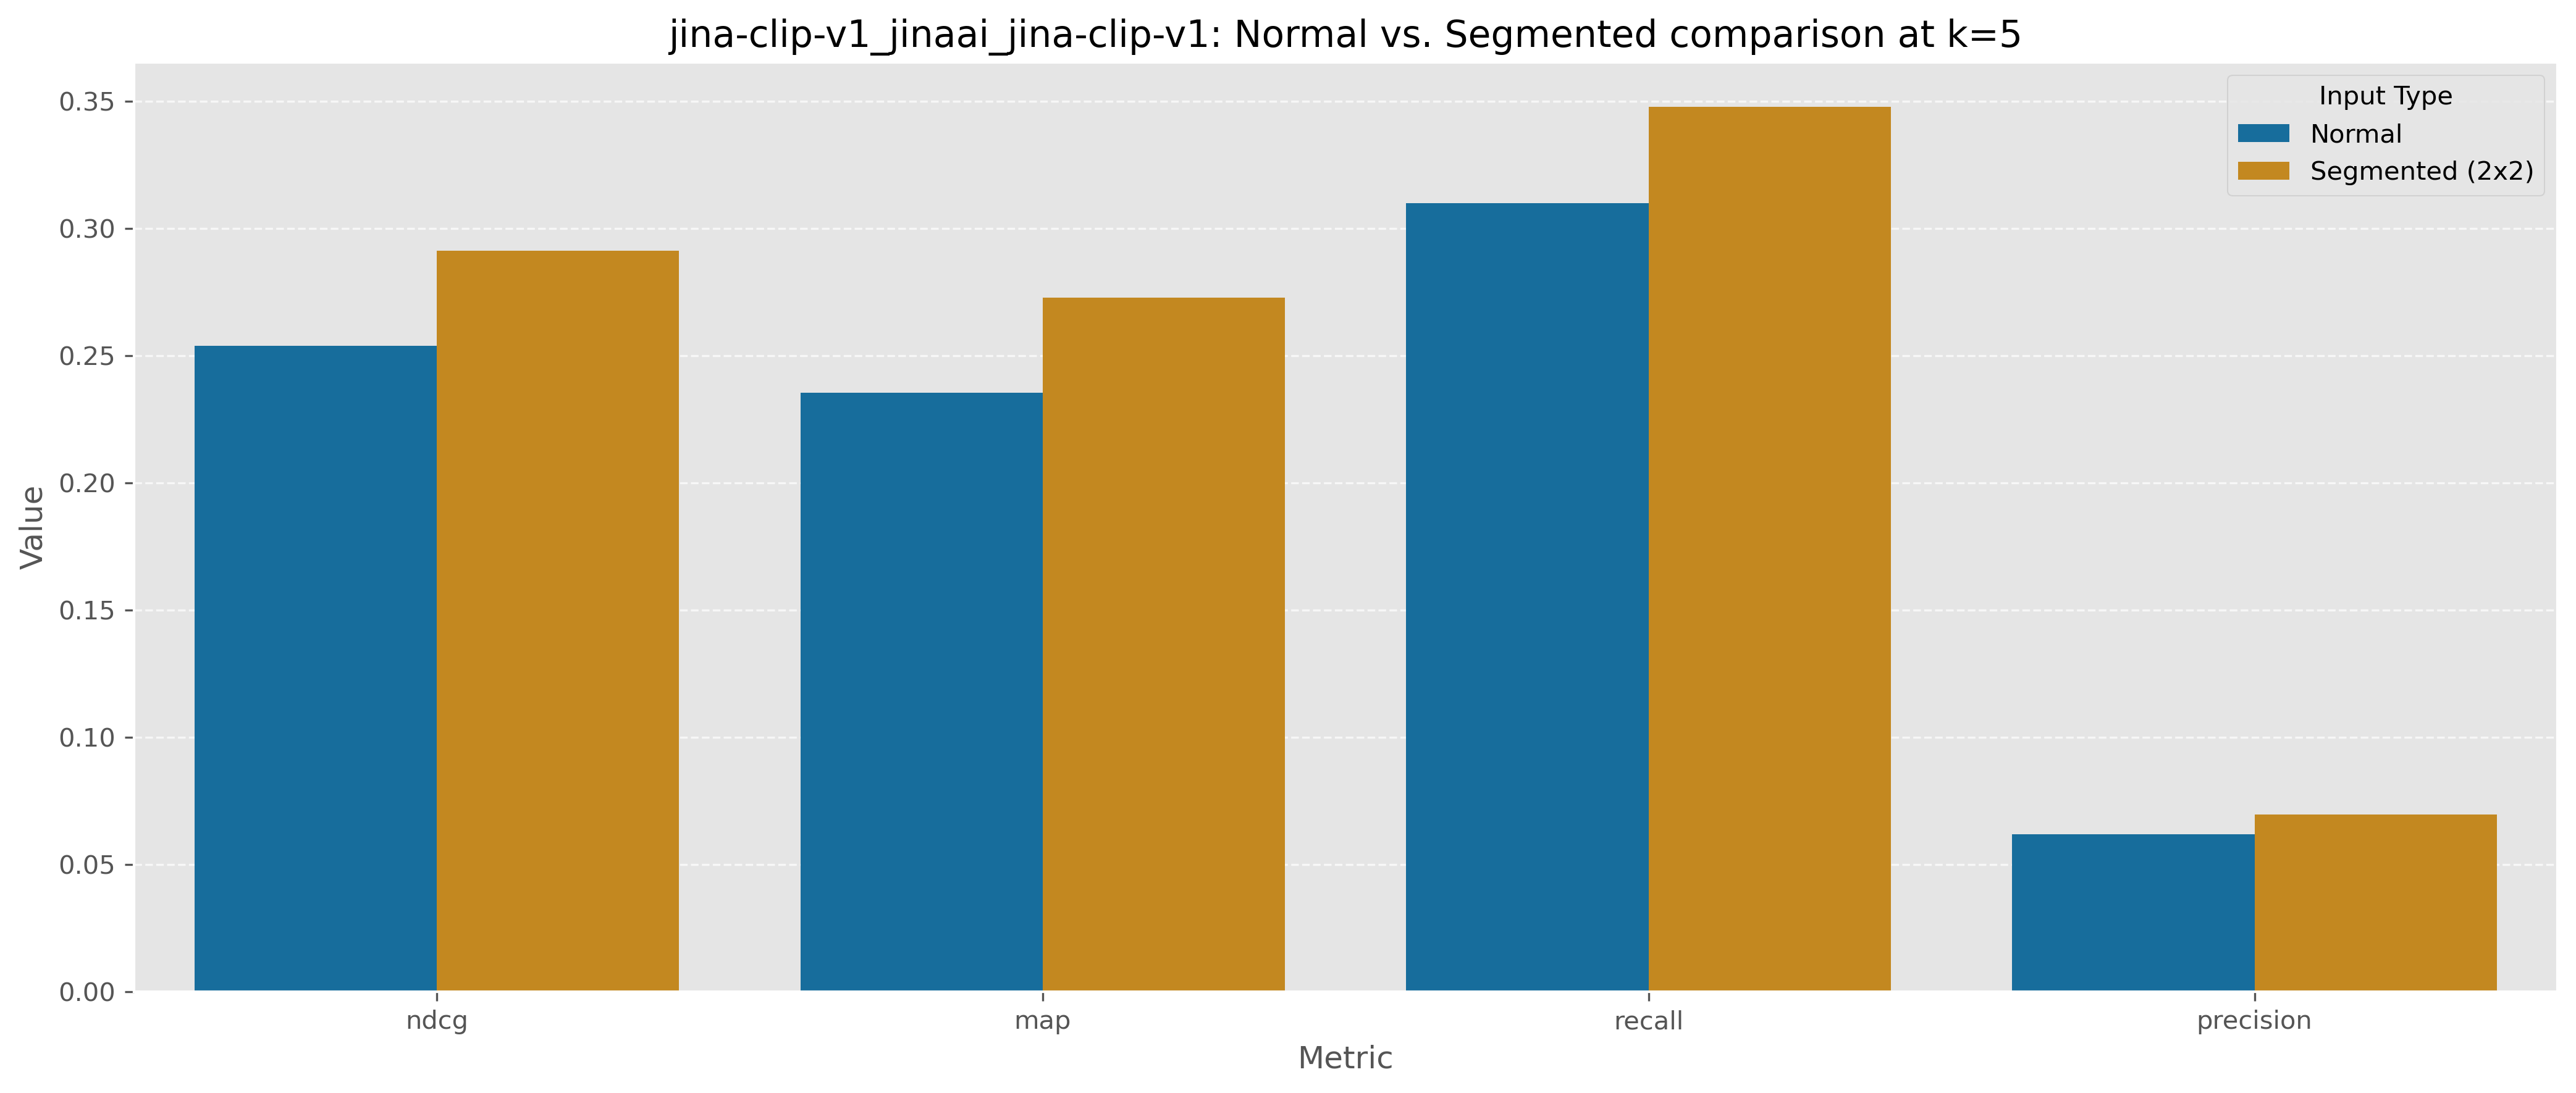

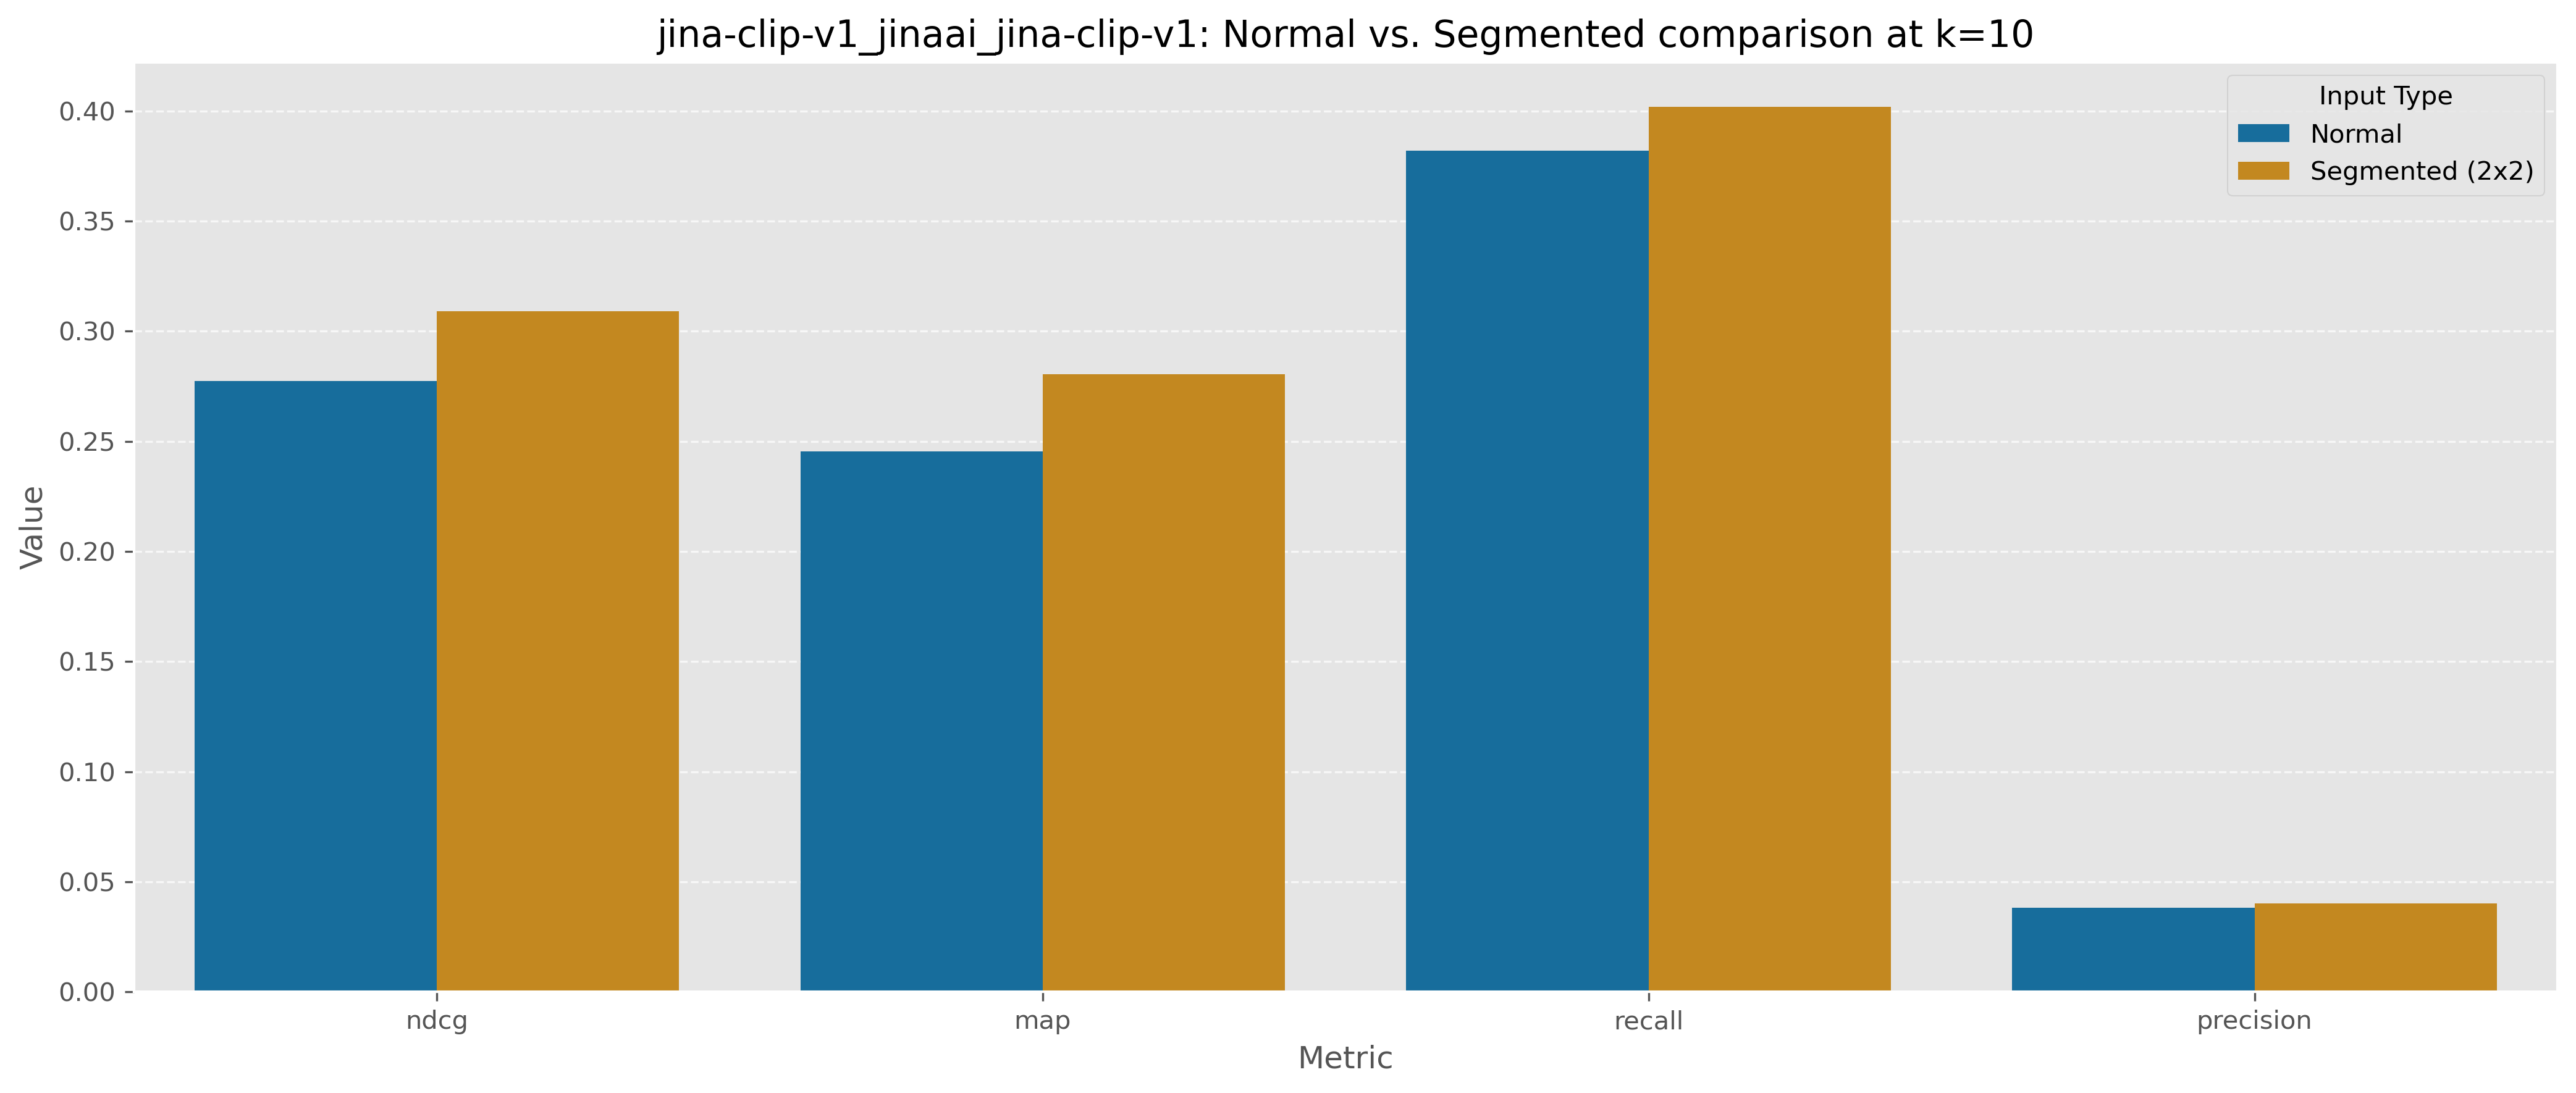

In [22]:
# Create bar charts comparing normal vs segmented at k=5 and k=10
for base_model_name in paired_models.keys():
    print(f"\n## {base_model_name} - Performance at specific k values")
    compare_normal_vs_segmented_at_k(base_model_name, 5)
    compare_normal_vs_segmented_at_k(base_model_name, 10)

In [23]:
# Calculate performance improvement/decline from normal to segmented
improvement_data = []

for base_name, df in model_comparison_dfs.items():
    # Create a pivot table to easily compare normal vs segmented
    pivot = df.pivot_table(index=['Metric', 'k'], columns='Variant', values='Value')
    
    # Get the columns for normal and segmented variants
    normal_col = [col for col in pivot.columns if 'Normal' in col][0] if any('Normal' in col for col in pivot.columns) else None
    segmented_cols = [col for col in pivot.columns if 'Segmented' in col]
    
    if normal_col and segmented_cols:
        for seg_col in segmented_cols:
            # Calculate improvement percentage
            pivot['improvement'] = (pivot[seg_col] - pivot[normal_col]) / pivot[normal_col] * 100
            
            # Add to the improvement data
            for (metric, k), row in pivot.iterrows():
                improvement_data.append({
                    'Base Model': base_name,
                    'Segmentation': seg_col,
                    'Metric': metric,
                    'k': k,
                    'Normal Value': row[normal_col],
                    'Segmented Value': row[seg_col],
                    'Improvement (%)': row['improvement']
                })

improvement_df = pd.DataFrame(improvement_data)
improvement_df.head(10)

Base Model     Segmentation Metric    k  \
0  jina-clip-v1_jinaai_jina-clip-v1  Segmented (2x2)    map    1   
1  jina-clip-v1_jinaai_jina-clip-v1  Segmented (2x2)    map    3   
2  jina-clip-v1_jinaai_jina-clip-v1  Segmented (2x2)    map    5   
3  jina-clip-v1_jinaai_jina-clip-v1  Segmented (2x2)    map   10   
4  jina-clip-v1_jinaai_jina-clip-v1  Segmented (2x2)    map   20   
5  jina-clip-v1_jinaai_jina-clip-v1  Segmented (2x2)    map   50   
6  jina-clip-v1_jinaai_jina-clip-v1  Segmented (2x2)    map  100   
7  jina-clip-v1_jinaai_jina-clip-v1  Segmented (2x2)   ndcg    1   
8  jina-clip-v1_jinaai_jina-clip-v1  Segmented (2x2)   ndcg    3   
9  jina-clip-v1_jinaai_jina-clip-v1  Segmented (2x2)   ndcg    5   

   Normal Value  Segmented Value  Improvement (%)  
0       0.19400          0.23400        20.618557  
1       0.22467          0.26133        16.317265  
2       0.23557          0.27283        15.816955  
3       0.24536          0.28041        14.285132  
4       0.25102          0.28639        14.090511  
5       0.25524          0.28998        13.610719  
6       0.25699          0.29190        13.584186  
7       0.19400          0.23400        20.618557  
8       0.23428          0.27024        15.349155  
9       0.25399          0.29132        14.697429

In [24]:
# Create heatmap showing improvement percentage for each model and metric at k=10
def plot_improvement_heatmap(k_value):
    k_improvement = improvement_df[improvement_df['k'] == k_value]
    
    # Create pivot table for the heatmap
    heatmap_data = k_improvement.pivot_table(index='Base Model', columns='Metric', values='Improvement (%)')
    
    plt.figure(figsize=(12, len(heatmap_data) * 0.8), dpi=300)
    sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn", center=0, fmt=".2f", linewidths=.5)
    plt.title(f'Performance improvement (%) from Normal to Segmented at k={k_value}')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_313005/74360483.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


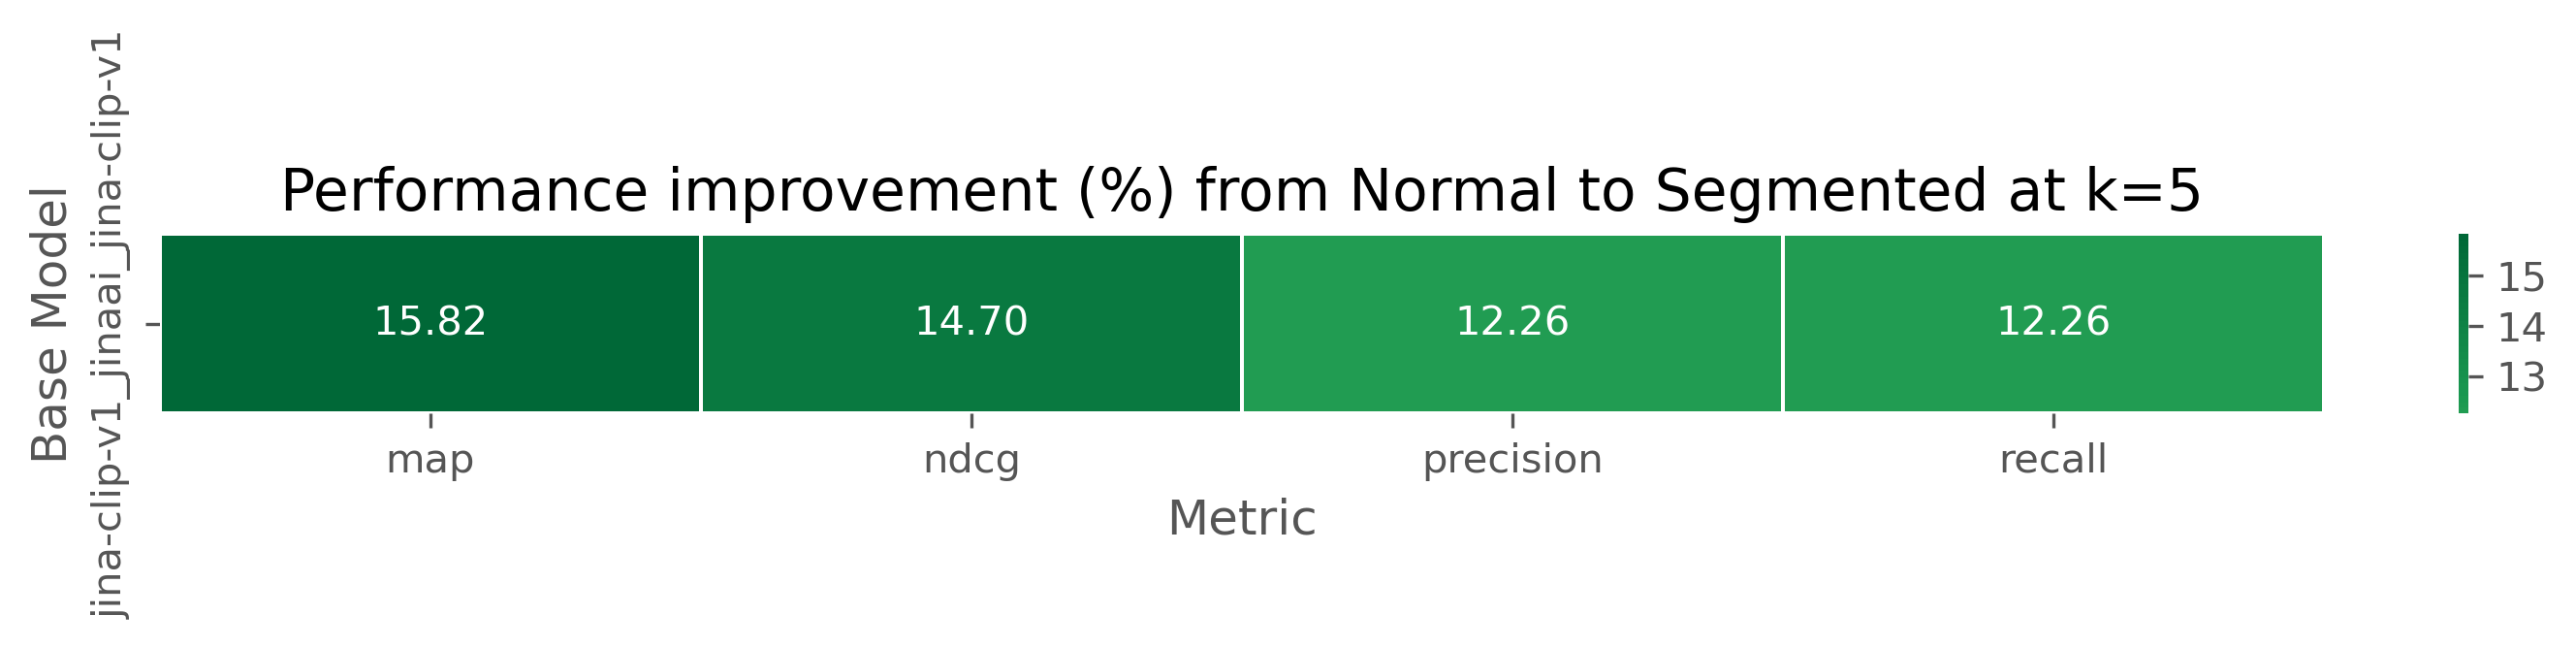

/tmp/ipykernel_313005/74360483.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


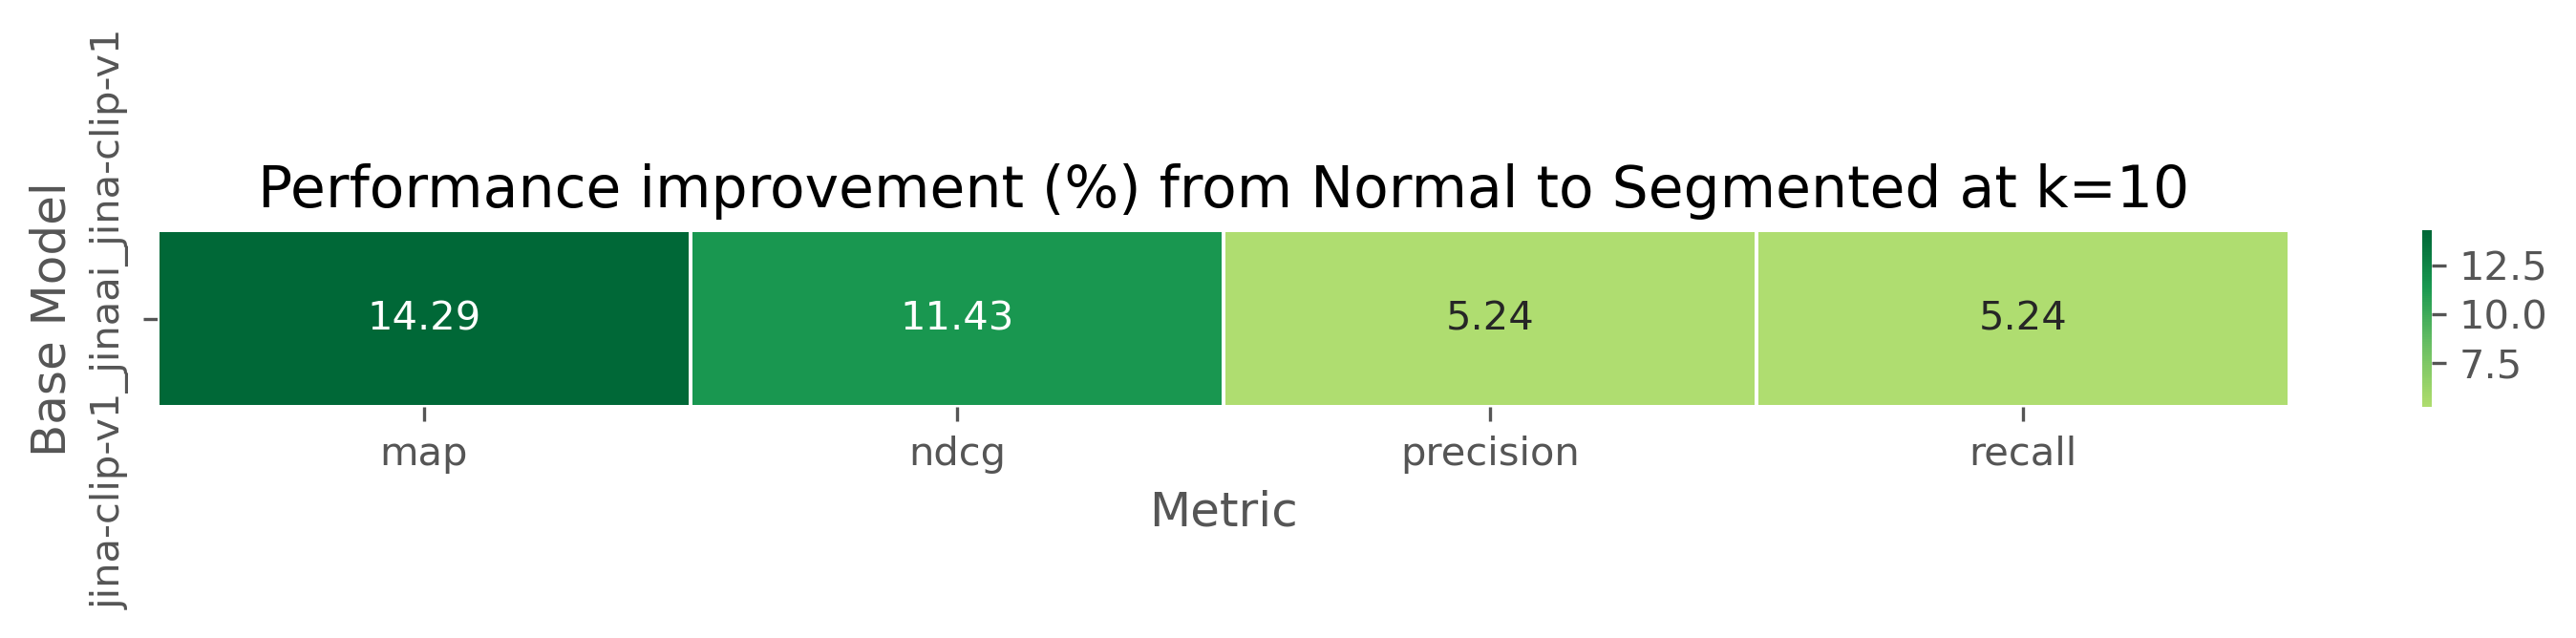

In [25]:
# Plot improvement heatmaps at k=5 and k=10
plot_improvement_heatmap(5)
plot_improvement_heatmap(10)